# CNN + GlobalAvgPool 
Non-coding RNA 1-5K.   
Loop over all cell lines, one at a time.

Conv1d + GlobalAvgPool1d + Dense(1).

This model sometimes predicted the majority class, sometimes was overfitting, and sometimes was doing fantastic (90% validation acc).   

In [36]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-03 14:11:40.998028
Python 3.8.16
sklearn 1.0.2


In [37]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=10
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=5000   

In [38]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [39]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [40]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [41]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq

## Model

In [42]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [43]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-03 14:11:42.140447
COMPILE
Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_183 (Embedding)   (None, 4997, 4)           1028      
                                                                 
 conv1d_183 (Conv1D)         (None, 4990, 64)          2112      
                                                                 
 global_average_pooling1d_18  (None, 64)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_367 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [44]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

## Driver

-------------
2023-01-03 14:11:42.262356
Cell line for today: 0 = A549
Load RCI values...
Num RCI: 1447
Load genes...
2023-01-03 14:11:42.275716
Load sequence...
2023-01-03 14:11:49.780895
Num IDs: 4828
Count 2488 ones out of 4828 labels.
Num counts: 4828
2023-01-03 14:11:49.782001
splitting
Fold 1
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (3905, 4997) (3905, 1)
Valid sizes (923, 4997) (923, 1)
Train set ones/size 1969 / 3905
Valid set ones/size 519 / 923
BUILD MODEL
COMPILE
FIT
2023-01-03 14:11:51.365800
Epoch 1/10
123/123 [==============================] - 2s 10ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.7011 - val_accuracy: 0.4301
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 0.6695 - accuracy: 0.5928 - val_loss: 0.7300 - val_accuracy: 0.5125
Epoch 3/10
123/123 [==============================] - 1s 10ms/step - loss: 0.6539 - accuracy: 0.6154 - val_loss: 0.7147 - val_accuracy: 0.5265
Epoch 4/10
123/123 [========================

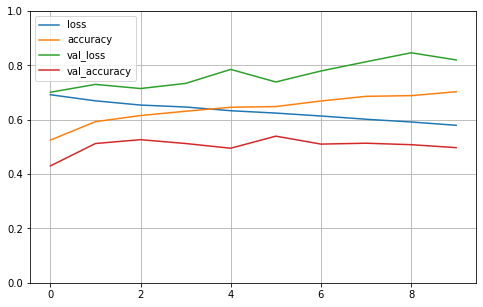

Compute valiation accuracy
2023-01-03 14:12:12.632346
Range of scores: 0.006802823 to 0.9947515
Predicted zeros and ones 406 517
Accuracy: 49.73% Precision: 55.32% Recall: 55.11% F1: 55.21%
2023-01-03 14:12:12.877769
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (3845, 4997) (3845, 1)
Valid sizes (983, 4997) (983, 1)
Train set ones/size 2012 / 3845
Valid set ones/size 476 / 983
BUILD MODEL
COMPILE
FIT
2023-01-03 14:12:14.366890
Epoch 1/10
121/121 [==============================] - 2s 10ms/step - loss: 0.6904 - accuracy: 0.5248 - val_loss: 0.6985 - val_accuracy: 0.4924
Epoch 2/10
121/121 [==============================] - 1s 8ms/step - loss: 0.6736 - accuracy: 0.5839 - val_loss: 0.7023 - val_accuracy: 0.5259
Epoch 3/10
121/121 [==============================] - 1s 8ms/step - loss: 0.6591 - accuracy: 0.6094 - val_loss: 0.7096 - val_accuracy: 0.5270
Epoch 4/10
121/121 [==============================] - 1s 9ms/step - loss: 0.6516 - accuracy: 0.6231 - val_loss: 0.6960 - 

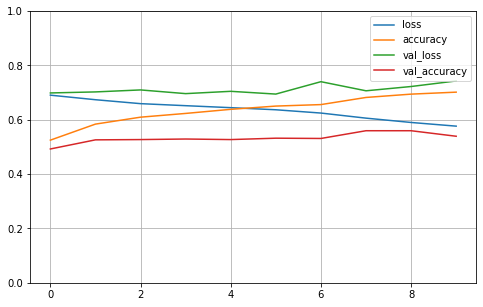

Compute valiation accuracy
2023-01-03 14:12:35.591983
Range of scores: 0.012430198 to 0.9668196
Predicted zeros and ones 342 641
Accuracy: 53.92% Precision: 51.79% Recall: 69.75% F1: 59.44%
2023-01-03 14:12:35.796542
Fold 3
Training example
[211  74  38 ...   0   0   0]
Train sizes (4062, 4997) (4062, 1)
Valid sizes (766, 4997) (766, 1)
Train set ones/size 2039 / 4062
Valid set ones/size 449 / 766
BUILD MODEL
COMPILE
FIT
2023-01-03 14:12:37.231847
Epoch 1/10
127/127 [==============================] - 2s 10ms/step - loss: 0.6930 - accuracy: 0.4975 - val_loss: 0.6888 - val_accuracy: 0.6018
Epoch 2/10
127/127 [==============================] - 1s 9ms/step - loss: 0.6796 - accuracy: 0.5788 - val_loss: 0.6927 - val_accuracy: 0.5131
Epoch 3/10
127/127 [==============================] - 1s 9ms/step - loss: 0.6622 - accuracy: 0.6046 - val_loss: 0.6925 - val_accuracy: 0.5117
Epoch 4/10
127/127 [==============================] - 1s 8ms/step - loss: 0.6539 - accuracy: 0.6214 - val_loss: 0.7036 - 

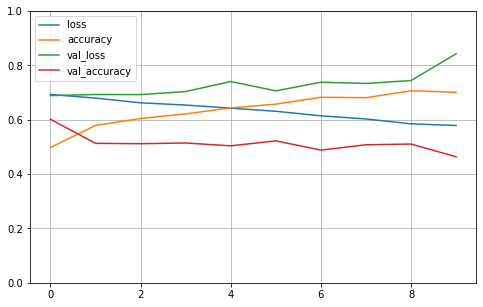

Compute valiation accuracy
2023-01-03 14:12:49.027358
Range of scores: 0.008350529 to 0.9854614
Predicted zeros and ones 594 172
Accuracy: 46.34% Precision: 61.05% Recall: 23.39% F1: 33.82%
2023-01-03 14:12:49.276343
Fold 4
Training example
[211  74  38 ...   0   0   0]
Train sizes (3421, 4997) (3421, 1)
Valid sizes (1407, 4997) (1407, 1)
Train set ones/size 1894 / 3421
Valid set ones/size 594 / 1407
BUILD MODEL
COMPILE
FIT
2023-01-03 14:12:50.709368
Epoch 1/10
107/107 [==============================] - 2s 11ms/step - loss: 0.6878 - accuracy: 0.5536 - val_loss: 0.7202 - val_accuracy: 0.4222
Epoch 2/10
107/107 [==============================] - 1s 9ms/step - loss: 0.6835 - accuracy: 0.5618 - val_loss: 0.7141 - val_accuracy: 0.4492
Epoch 3/10
107/107 [==============================] - 1s 9ms/step - loss: 0.6768 - accuracy: 0.5843 - val_loss: 0.6899 - val_accuracy: 0.4854
Epoch 4/10
107/107 [==============================] - 1s 9ms/step - loss: 0.6693 - accuracy: 0.6022 - val_loss: 0.6782

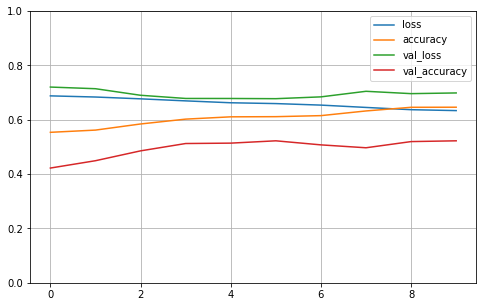

Compute valiation accuracy
2023-01-03 14:13:01.712063
Range of scores: 0.043723088 to 0.9456381
Predicted zeros and ones 237 1170
Accuracy: 52.24% Precision: 46.67% Recall: 91.92% F1: 61.90%
2023-01-03 14:13:01.964825
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (4079, 4997) (4079, 1)
Valid sizes (749, 4997) (749, 1)
Train set ones/size 2038 / 4079
Valid set ones/size 450 / 749
BUILD MODEL
COMPILE
FIT
2023-01-03 14:13:03.418350
Epoch 1/10
128/128 [==============================] - 2s 10ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6997 - val_accuracy: 0.3992
Epoch 2/10
128/128 [==============================] - 1s 8ms/step - loss: 0.6873 - accuracy: 0.5445 - val_loss: 0.6633 - val_accuracy: 0.6769
Epoch 3/10
128/128 [==============================] - 1s 8ms/step - loss: 0.6719 - accuracy: 0.5815 - val_loss: 0.6411 - val_accuracy: 0.6849
Epoch 4/10
128/128 [==============================] - 1s 8ms/step - loss: 0.6620 - accuracy: 0.6055 - val_loss: 0.6664 -

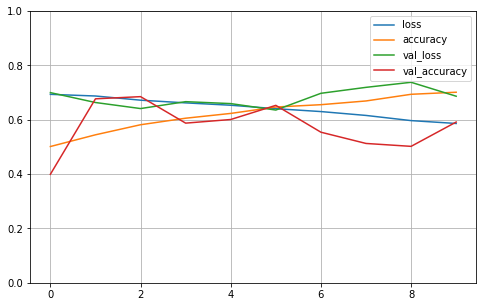

Compute valiation accuracy
2023-01-03 14:13:15.154111
Range of scores: 0.002120193 to 0.9885825
Predicted zeros and ones 343 406
Accuracy: 59.15% Precision: 67.73% Recall: 61.11% F1: 64.25%
2023-01-03 14:13:15.407706

Cross validation 5 folds 10 epochs
 accuracy mean 52.27% +/- 4.28
 precision mean 56.51% +/- 7.31
 recall mean 60.25% +/- 22.27
 F1 mean 54.93% +/- 10.97
2023-01-03 14:13:15.412508
-------------
2023-01-03 14:13:15.412568
Cell line for today: 1 = H1.hESC
Load RCI values...
Num RCI: 3327
Load genes...
2023-01-03 14:13:15.423997
Load sequence...
2023-01-03 14:13:28.369668
Num IDs: 8955
Count 3205 ones out of 8955 labels.
Num counts: 8955
2023-01-03 14:13:28.370999
splitting
Fold 1
Training example
[149  84  80 ...   0   0   0]
Train sizes (7123, 4997) (7123, 1)
Valid sizes (1832, 4997) (1832, 1)
Train set ones/size 2559 / 7123
Valid set ones/size 646 / 1832
BUILD MODEL
COMPILE
FIT
2023-01-03 14:13:31.110096
Epoch 1/10
223/223 [==============================] - 3s 9ms/step -

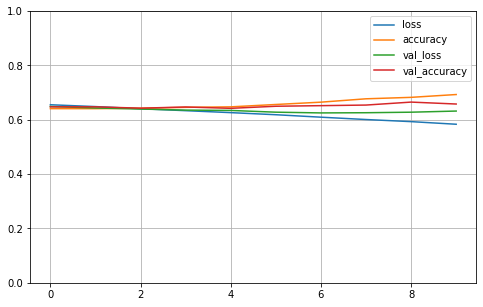

Compute valiation accuracy
2023-01-03 14:13:52.515824
Range of scores: 0.019535325 to 0.8878737
Predicted zeros and ones 1567 265
Accuracy: 65.78% Precision: 53.58% Recall: 21.98% F1: 31.17%
2023-01-03 14:13:52.887100
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (7185, 4997) (7185, 1)
Valid sizes (1770, 4997) (1770, 1)
Train set ones/size 2568 / 7185
Valid set ones/size 637 / 1770
BUILD MODEL
COMPILE
FIT
2023-01-03 14:13:55.586156
Epoch 1/10
225/225 [==============================] - 3s 9ms/step - loss: 0.6544 - accuracy: 0.6418 - val_loss: 0.6499 - val_accuracy: 0.6401
Epoch 2/10
225/225 [==============================] - 2s 9ms/step - loss: 0.6486 - accuracy: 0.6426 - val_loss: 0.6434 - val_accuracy: 0.6401
Epoch 3/10
225/225 [==============================] - 2s 8ms/step - loss: 0.6432 - accuracy: 0.6427 - val_loss: 0.6307 - val_accuracy: 0.6469
Epoch 4/10
225/225 [==============================] - 2s 8ms/step - loss: 0.6371 - accuracy: 0.6438 - val_loss: 0.6246

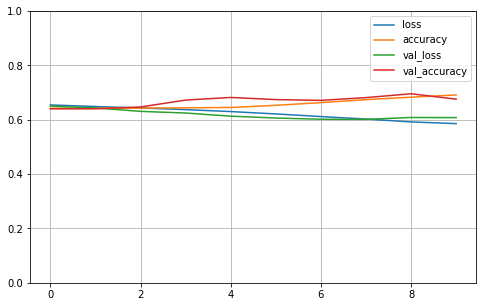

Compute valiation accuracy
2023-01-03 14:14:17.003180
Range of scores: 0.00013495814 to 0.8845649
Predicted zeros and ones 1511 259
Accuracy: 67.57% Precision: 62.16% Recall: 25.27% F1: 35.94%
2023-01-03 14:14:17.289330
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (7349, 4997) (7349, 1)
Valid sizes (1606, 4997) (1606, 1)
Train set ones/size 2699 / 7349
Valid set ones/size 506 / 1606
BUILD MODEL
COMPILE
FIT
2023-01-03 14:14:19.902951
Epoch 1/10
230/230 [==============================] - 3s 10ms/step - loss: 0.6592 - accuracy: 0.6326 - val_loss: 0.6300 - val_accuracy: 0.6849
Epoch 2/10
230/230 [==============================] - 2s 8ms/step - loss: 0.6503 - accuracy: 0.6323 - val_loss: 0.6240 - val_accuracy: 0.6812
Epoch 3/10
230/230 [==============================] - 2s 9ms/step - loss: 0.6389 - accuracy: 0.6374 - val_loss: 0.6139 - val_accuracy: 0.6719
Epoch 4/10
230/230 [==============================] - 2s 8ms/step - loss: 0.6287 - accuracy: 0.6423 - val_loss: 0.6

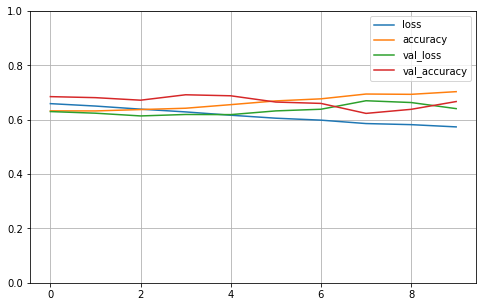

Compute valiation accuracy
2023-01-03 14:14:41.685743
Range of scores: 0.001547634 to 0.91012406
Predicted zeros and ones 1337 269
Accuracy: 66.69% Precision: 44.61% Recall: 23.72% F1: 30.97%
2023-01-03 14:14:41.947113
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (7021, 4997) (7021, 1)
Valid sizes (1934, 4997) (1934, 1)
Train set ones/size 2540 / 7021
Valid set ones/size 665 / 1934
BUILD MODEL
COMPILE
FIT
2023-01-03 14:14:44.534613
Epoch 1/10
220/220 [==============================] - 3s 9ms/step - loss: 0.6558 - accuracy: 0.6381 - val_loss: 0.6449 - val_accuracy: 0.6562
Epoch 2/10
220/220 [==============================] - 2s 8ms/step - loss: 0.6425 - accuracy: 0.6414 - val_loss: 0.6619 - val_accuracy: 0.6101
Epoch 3/10
220/220 [==============================] - 2s 9ms/step - loss: 0.6278 - accuracy: 0.6491 - val_loss: 0.6732 - val_accuracy: 0.5853
Epoch 4/10
220/220 [==============================] - 2s 9ms/step - loss: 0.6163 - accuracy: 0.6620 - val_loss: 0.692

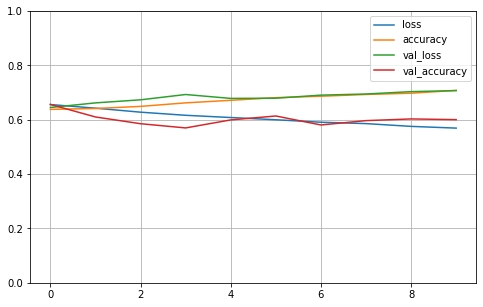

Compute valiation accuracy
2023-01-03 14:15:04.656760
Range of scores: 0.0023379994 to 0.990606
Predicted zeros and ones 1644 290
Accuracy: 60.03% Precision: 31.38% Recall: 13.68% F1: 19.06%
2023-01-03 14:15:05.092587
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (7142, 4997) (7142, 1)
Valid sizes (1813, 4997) (1813, 1)
Train set ones/size 2454 / 7142
Valid set ones/size 751 / 1813
BUILD MODEL
COMPILE
FIT
2023-01-03 14:15:07.677100
Epoch 1/10
224/224 [==============================] - 3s 10ms/step - loss: 0.6468 - accuracy: 0.6556 - val_loss: 0.6973 - val_accuracy: 0.5858
Epoch 2/10
224/224 [==============================] - 2s 8ms/step - loss: 0.6405 - accuracy: 0.6564 - val_loss: 0.6802 - val_accuracy: 0.5858
Epoch 3/10
224/224 [==============================] - 2s 9ms/step - loss: 0.6354 - accuracy: 0.6568 - val_loss: 0.6589 - val_accuracy: 0.5885
Epoch 4/10
224/224 [==============================] - 2s 8ms/step - loss: 0.6294 - accuracy: 0.6589 - val_loss: 0.648

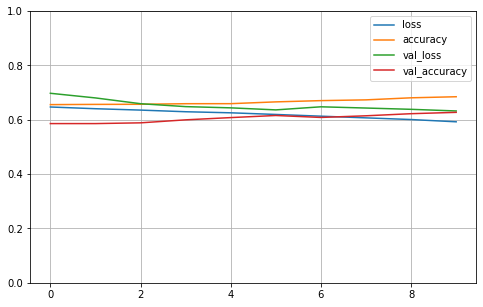

Compute valiation accuracy
2023-01-03 14:15:27.926231
Range of scores: 0.0054025603 to 0.9563854
Predicted zeros and ones 1588 225
Accuracy: 62.71% Precision: 66.67% Recall: 19.97% F1: 30.74%
2023-01-03 14:15:28.359183

Cross validation 5 folds 10 epochs
 accuracy mean 64.56% +/- 2.79
 precision mean 51.68% +/- 12.65
 recall mean 20.93% +/- 4.03
 F1 mean 29.58% +/- 5.60
2023-01-03 14:15:28.363715
-------------
2023-01-03 14:15:28.363774
Cell line for today: 2 = HeLa.S3
Load RCI values...
Num RCI: 919
Load genes...
2023-01-03 14:15:28.374715
Load sequence...
2023-01-03 14:15:32.937059
Num IDs: 3196
Count 738 ones out of 3196 labels.
Num counts: 3196
2023-01-03 14:15:32.940180
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (2728, 4997) (2728, 1)
Valid sizes (468, 4997) (468, 1)
Train set ones/size 576 / 2728
Valid set ones/size 162 / 468
BUILD MODEL
COMPILE
FIT
2023-01-03 14:15:34.278532
Epoch 1/10
86/86 [==============================] - 2s 11ms/step - loss:

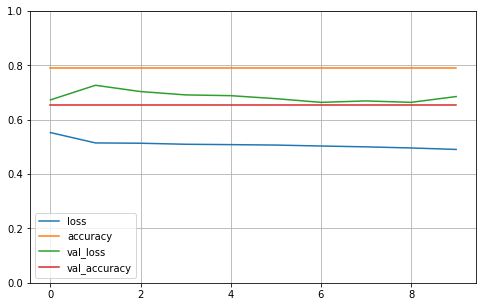

Compute valiation accuracy
2023-01-03 14:15:45.321287
Range of scores: 0.04203158 to 0.2872713
Predicted zeros and ones 468 0
Accuracy: 65.38% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:15:45.467222
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2420, 4997) (2420, 1)
Valid sizes (776, 4997) (776, 1)
Train set ones/size 534 / 2420
Valid set ones/size 204 / 776
BUILD MODEL
COMPILE
FIT
2023-01-03 14:15:46.440031
Epoch 1/10
76/76 [==============================] - 1s 13ms/step - loss: 0.5681 - accuracy: 0.7777 - val_loss: 0.5855 - val_accuracy: 0.7371
Epoch 2/10
76/76 [==============================] - 1s 9ms/step - loss: 0.5287 - accuracy: 0.7793 - val_loss: 0.5877 - val_accuracy: 0.7371
Epoch 3/10
76/76 [==============================] - 1s 9ms/step - loss: 0.5283 - accuracy: 0.7793 - val_loss: 0.5746 - val_accuracy: 0.7371
Epoch 4/10
76/76 [==============================] - 1s 9ms/step - loss: 0.5259 - accuracy: 0.7793 - val_loss: 0.5786 - val_accuracy: 0.7371
Epoch 5/10
76/76 [==============================] - 1s 9ms/step - loss: 0.5241 - accuracy: 0.7793 - val_loss: 0.5834 - val_accuracy: 0.7371
Epoch 6/10
76/76 [==============================] - 1s 9ms/step - loss: 

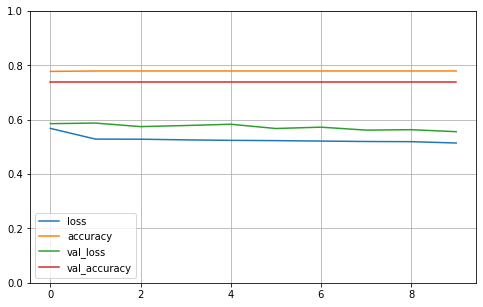

Compute valiation accuracy
2023-01-03 14:15:57.392548
Range of scores: 0.14162889 to 0.2847359
Predicted zeros and ones 776 0
Accuracy: 73.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:15:57.630983
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2313, 4997) (2313, 1)
Valid sizes (883, 4997) (883, 1)
Train set ones/size 558 / 2313
Valid set ones/size 180 / 883
BUILD MODEL
COMPILE
FIT
2023-01-03 14:15:58.619637
Epoch 1/10
73/73 [==============================] - 1s 13ms/step - loss: 0.5814 - accuracy: 0.7588 - val_loss: 0.5065 - val_accuracy: 0.7961
Epoch 2/10
73/73 [==============================] - 1s 10ms/step - loss: 0.5517 - accuracy: 0.7588 - val_loss: 0.5068 - val_accuracy: 0.7961
Epoch 3/10
73/73 [==============================] - 1s 10ms/step - loss: 0.5475 - accuracy: 0.7588 - val_loss: 0.5104 - val_accuracy: 0.7961
Epoch 4/10
73/73 [==============================] - 1s 10ms/step - loss: 0.5442 - accuracy: 0.7588 - val_loss: 0.5146 - val_accuracy: 0.7961
Epoch 5/10
73/73 [==============================] - 1s 10ms/step - loss: 0.5411 - accuracy: 0.7588 - val_loss: 0.5240 - val_accuracy: 0.7961
Epoch 6/10
73/73 [==============================] - 1s 9ms/step - lo

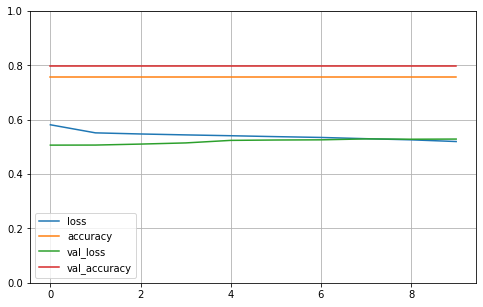

Compute valiation accuracy
2023-01-03 14:16:06.625322
Range of scores: 0.02015504 to 0.41210052
Predicted zeros and ones 883 0
Accuracy: 79.61% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:16:06.878085
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2711, 4997) (2711, 1)
Valid sizes (485, 4997) (485, 1)
Train set ones/size 661 / 2711
Valid set ones/size 77 / 485
BUILD MODEL
COMPILE
FIT
2023-01-03 14:16:07.843063
Epoch 1/10
85/85 [==============================] - 1s 11ms/step - loss: 0.5866 - accuracy: 0.7481 - val_loss: 0.4629 - val_accuracy: 0.8412
Epoch 2/10
85/85 [==============================] - 1s 8ms/step - loss: 0.5534 - accuracy: 0.7562 - val_loss: 0.4530 - val_accuracy: 0.8412
Epoch 3/10
85/85 [==============================] - 1s 10ms/step - loss: 0.5506 - accuracy: 0.7562 - val_loss: 0.4757 - val_accuracy: 0.8412
Epoch 4/10
85/85 [==============================] - 1s 8ms/step - loss: 0.5498 - accuracy: 0.7562 - val_loss: 0.4447 - val_accuracy: 0.8412
Epoch 5/10
85/85 [==============================] - 1s 8ms/step - loss: 0.5452 - accuracy: 0.7562 - val_loss: 0.4543 - val_accuracy: 0.8412
Epoch 6/10
85/85 [==============================] - 1s 8ms/step - loss: 

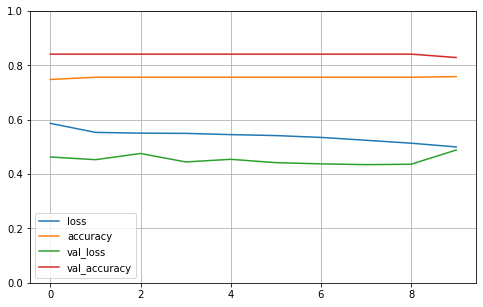

Compute valiation accuracy
2023-01-03 14:16:18.810901
Range of scores: 0.027475754 to 0.6911645
Predicted zeros and ones 479 6
Accuracy: 82.89% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:16:18.963790
Fold 5
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2612, 4997) (2612, 1)
Valid sizes (584, 4997) (584, 1)
Train set ones/size 623 / 2612
Valid set ones/size 115 / 584
BUILD MODEL
COMPILE
FIT
2023-01-03 14:16:19.895337
Epoch 1/10
82/82 [==============================] - 1s 11ms/step - loss: 0.5815 - accuracy: 0.7569 - val_loss: 0.5044 - val_accuracy: 0.8031
Epoch 2/10
82/82 [==============================] - 1s 9ms/step - loss: 0.5491 - accuracy: 0.7615 - val_loss: 0.4996 - val_accuracy: 0.8031
Epoch 3/10
82/82 [==============================] - 1s 8ms/step - loss: 0.5463 - accuracy: 0.7615 - val_loss: 0.5021 - val_accuracy: 0.8031
Epoch 4/10
82/82 [==============================] - 1s 10ms/step - loss: 0.5423 - accuracy: 0.7615 - val_loss: 0.4934 - val_accuracy:

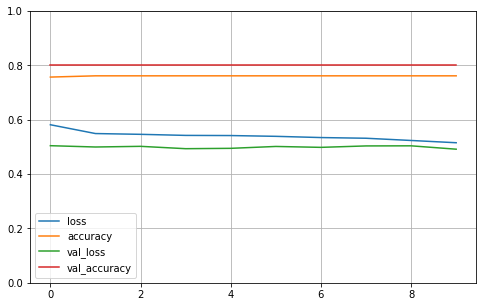

Compute valiation accuracy
2023-01-03 14:16:28.421824
Range of scores: 0.060409233 to 0.3293735
Predicted zeros and ones 584 0
Accuracy: 80.31% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:16:28.569760

Cross validation 5 folds 10 epochs
 accuracy mean 76.38% +/- 6.27
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 14:16:28.570924
-------------
2023-01-03 14:16:28.570980
Cell line for today: 3 = HepG2
Load RCI values...
Num RCI: 1362
Load genes...
2023-01-03 14:16:28.594283
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 14:16:35.887786
Num IDs: 4771
Count 1320 ones out of 4771 labels.
Num counts: 4771
2023-01-03 14:16:35.890322
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
Train sizes (3945, 4997) (3945, 1)
Valid sizes (826, 4997) (826, 1)
Train set ones/size 1165 / 3945
Valid set ones/size 155 / 826
BUILD MODEL
COMPILE
FIT
2023-01-03 14:16:37.355911
Epoch 1/10
124/124 [==============================] - 2s 10ms/step - loss: 0.6185 - accuracy: 0.7022 - val_loss: 0.5040 - val_accuracy: 0.8123
Epoch 2/10
124/124 [==============================] - 1s 9ms/step - loss: 0.6015 - accuracy: 0.7047 - val_loss: 0.5242 - val_accuracy: 0.8123
Epoch 3/10
124/124 [==============================] - 1s 9ms/step - loss: 0.5960 - accuracy: 0.7047 - val_loss: 0.5023 - val_accuracy: 0.8123
Epoch 4/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5897 - accuracy: 0.7047 - val_loss: 0.5240 - val_accuracy: 0.8123
Epoch 5/10
124/124 [==============================] - 1s 8ms/step

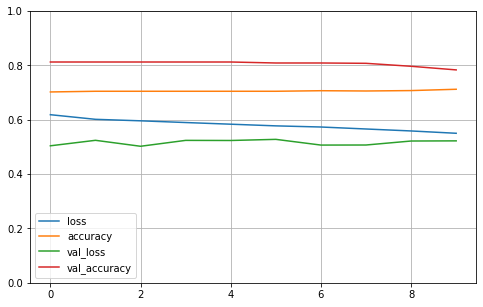

Compute valiation accuracy
2023-01-03 14:16:58.595594
Range of scores: 0.0071552102 to 0.7098864
Predicted zeros and ones 798 28
Accuracy: 78.33% Precision: 7.14% Recall: 1.29% F1: 2.19%
2023-01-03 14:16:58.781485
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (3964, 4997) (3964, 1)
Valid sizes (807, 4997) (807, 1)
Train set ones/size 1066 / 3964
Valid set ones/size 254 / 807
BUILD MODEL
COMPILE
FIT
2023-01-03 14:17:00.188064
Epoch 1/10
124/124 [==============================] - 2s 10ms/step - loss: 0.5960 - accuracy: 0.7291 - val_loss: 0.6306 - val_accuracy: 0.6853
Epoch 2/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5801 - accuracy: 0.7311 - val_loss: 0.6252 - val_accuracy: 0.6853
Epoch 3/10
124/124 [==============================] - 1s 9ms/step - loss: 0.5759 - accuracy: 0.7311 - val_loss: 0.6241 - val_accuracy: 0.6853
Epoch 4/10
124/124 [==============================] - 1s 9ms/step - loss: 0.5707 - accuracy: 0.7311 - val_loss: 0.6211 - val

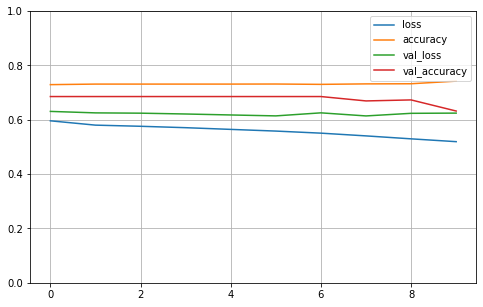

Compute valiation accuracy
2023-01-03 14:17:21.393912
Range of scores: 0.012058322 to 0.78281647
Predicted zeros and ones 736 71
Accuracy: 63.20% Precision: 19.72% Recall: 5.51% F1: 8.62%
2023-01-03 14:17:21.636790
Fold 3
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (3356, 4997) (3356, 1)
Valid sizes (1415, 4997) (1415, 1)
Train set ones/size 875 / 3356
Valid set ones/size 445 / 1415
BUILD MODEL
COMPILE
FIT
2023-01-03 14:17:23.040210
Epoch 1/10
105/105 [==============================] - 2s 13ms/step - loss: 0.5900 - accuracy: 0.7348 - val_loss: 0.6386 - val_accuracy: 0.6855
Epoch 2/10
105/105 [==============================] - 1s 9ms/step - loss: 0.5739 - accuracy: 0.7393 - val_loss: 0.6293 - val_accuracy: 0.6855
Epoch 3/10
105/105 [==============================] - 1s 11ms/step - loss: 0.5717 - accuracy: 0.7393 - val_loss: 0.6340 - val_accuracy: 0.6855
Epoch 4/10
105/105 [==============================] - 1s 12ms/step - loss: 0.5697 - accuracy: 0.7393 - val_loss: 0.6198 

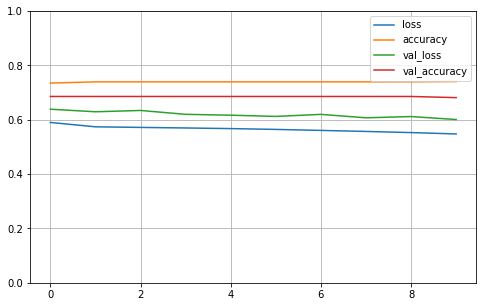

Compute valiation accuracy
2023-01-03 14:17:44.240545
Range of scores: 0.050210536 to 0.52546686
Predicted zeros and ones 1409 6
Accuracy: 68.13% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:17:44.497405
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (3720, 4997) (3720, 1)
Valid sizes (1051, 4997) (1051, 1)
Train set ones/size 960 / 3720
Valid set ones/size 360 / 1051
BUILD MODEL
COMPILE
FIT
2023-01-03 14:17:45.898372
Epoch 1/10
117/117 [==============================] - 2s 10ms/step - loss: 0.5908 - accuracy: 0.7371 - val_loss: 0.6508 - val_accuracy: 0.6575
Epoch 2/10
117/117 [==============================] - 1s 9ms/step - loss: 0.5684 - accuracy: 0.7419 - val_loss: 0.6625 - val_accuracy: 0.6575
Epoch 3/10
117/117 [==============================] - 1s 9ms/step - loss: 0.5660 - accuracy: 0.7419 - val_loss: 0.6580 - val_accuracy: 0.6575
Epoch 4/10
117/117 [==============================] - 1s 9ms/step - loss: 0.5628 - accuracy: 0.7419 - val_loss: 0.6637 - v

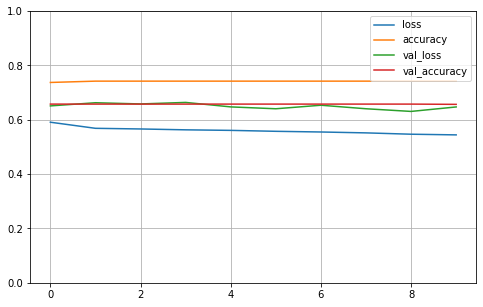

Compute valiation accuracy
2023-01-03 14:17:57.456979
Range of scores: 0.008505795 to 0.5039606
Predicted zeros and ones 1050 1
Accuracy: 65.65% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:17:57.653900
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (4099, 4997) (4099, 1)
Valid sizes (672, 4997) (672, 1)
Train set ones/size 1214 / 4099
Valid set ones/size 106 / 672
BUILD MODEL
COMPILE
FIT
2023-01-03 14:17:59.059588
Epoch 1/10
129/129 [==============================] - 2s 10ms/step - loss: 0.6183 - accuracy: 0.7036 - val_loss: 0.4947 - val_accuracy: 0.8423
Epoch 2/10
129/129 [==============================] - 1s 9ms/step - loss: 0.6036 - accuracy: 0.7038 - val_loss: 0.5044 - val_accuracy: 0.8423
Epoch 3/10
129/129 [==============================] - 1s 9ms/step - loss: 0.5984 - accuracy: 0.7038 - val_loss: 0.4904 - val_accuracy: 0.8423
Epoch 4/10
129/129 [==============================] - 1s 8ms/step - loss: 0.5923 - accuracy: 0.7038 - val_loss: 0.4953 - val_

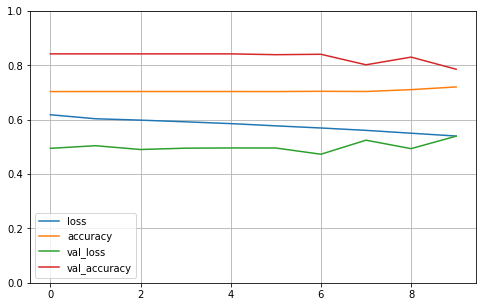

Compute valiation accuracy
2023-01-03 14:18:20.271161
Range of scores: 0.008754119 to 0.81878823
Predicted zeros and ones 612 60
Accuracy: 78.57% Precision: 18.33% Recall: 10.38% F1: 13.25%
2023-01-03 14:18:20.518406

Cross validation 5 folds 10 epochs
 accuracy mean 70.78% +/- 6.46
 precision mean 9.04% +/- 8.57
 recall mean 3.44% +/- 4.02
 F1 mean 4.81% +/- 5.27
2023-01-03 14:18:20.519752
-------------
2023-01-03 14:18:20.519807
Cell line for today: 4 = HT1080
Load RCI values...
Num RCI: 936
Load genes...
2023-01-03 14:18:20.532276
Load sequence...
2023-01-03 14:18:26.361585
Num IDs: 4112
Count 1902 ones out of 4112 labels.
Num counts: 4112
2023-01-03 14:18:26.364179
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (3422, 4997) (3422, 1)
Valid sizes (690, 4997) (690, 1)
Train set ones/size 1643 / 3422
Valid set ones/size 259 / 690
BUILD MODEL
COMPILE
FIT
2023-01-03 14:18:27.800395
Epoch 1/10
107/107 [==============================] - 2s 11ms/step - loss: 0.

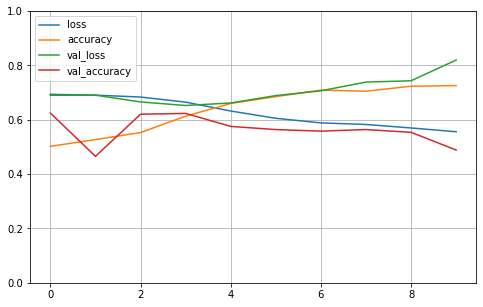

Compute valiation accuracy
2023-01-03 14:18:38.759968
Range of scores: 0.010196982 to 0.9978289
Predicted zeros and ones 258 432
Accuracy: 48.84% Precision: 39.12% Recall: 65.25% F1: 48.91%
2023-01-03 14:18:38.995961
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (3208, 4997) (3208, 1)
Valid sizes (904, 4997) (904, 1)
Train set ones/size 1283 / 3208
Valid set ones/size 619 / 904
BUILD MODEL
COMPILE
FIT
2023-01-03 14:18:40.208789
Epoch 1/10
101/101 [==============================] - 2s 11ms/step - loss: 0.6739 - accuracy: 0.6001 - val_loss: 0.8271 - val_accuracy: 0.3153
Epoch 2/10
101/101 [==============================] - 1s 9ms/step - loss: 0.6721 - accuracy: 0.6001 - val_loss: 0.8067 - val_accuracy: 0.3153
Epoch 3/10
101/101 [==============================] - 1s 9ms/step - loss: 0.6685 - accuracy: 0.6001 - val_loss: 0.7715 - val_accuracy: 0.3153
Epoch 4/10
101/101 [==============================] - 1s 9ms/step - loss: 0.6579 - accuracy: 0.5982 - val_loss: 0.8127 - 

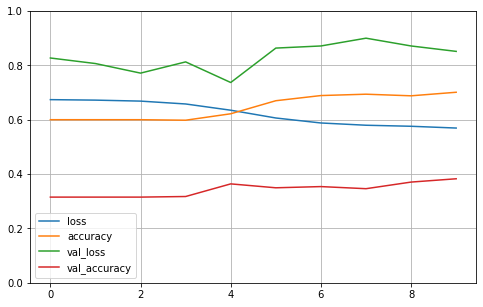

Compute valiation accuracy
2023-01-03 14:18:51.164742
Range of scores: 0.0045381472 to 0.94082135
Predicted zeros and ones 677 227
Accuracy: 38.27% Precision: 63.44% Recall: 23.26% F1: 34.04%
2023-01-03 14:18:51.352445
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (3331, 4997) (3331, 1)
Valid sizes (781, 4997) (781, 1)
Train set ones/size 1607 / 3331
Valid set ones/size 295 / 781
BUILD MODEL
COMPILE
FIT
2023-01-03 14:18:52.568724
Epoch 1/10
105/105 [==============================] - 2s 11ms/step - loss: 0.6925 - accuracy: 0.5119 - val_loss: 0.6890 - val_accuracy: 0.5813
Epoch 2/10
105/105 [==============================] - 1s 9ms/step - loss: 0.6899 - accuracy: 0.5251 - val_loss: 0.6896 - val_accuracy: 0.5134
Epoch 3/10
105/105 [==============================] - 1s 9ms/step - loss: 0.6832 - accuracy: 0.5644 - val_loss: 0.7054 - val_accuracy: 0.4507
Epoch 4/10
105/105 [==============================] - 1s 10ms/step - loss: 0.6744 - accuracy: 0.5911 - val_loss: 0.6625

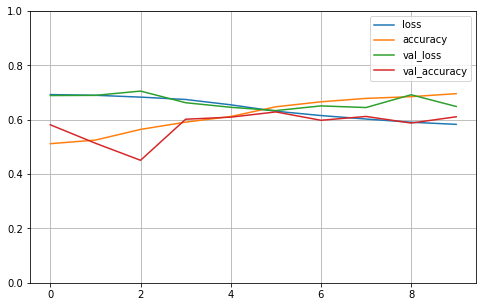

Compute valiation accuracy
2023-01-03 14:19:03.953058
Range of scores: 0.009043411 to 0.94363016
Predicted zeros and ones 444 337
Accuracy: 61.08% Precision: 48.66% Recall: 55.59% F1: 51.90%
2023-01-03 14:19:04.133955
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (3242, 4997) (3242, 1)
Valid sizes (870, 4997) (870, 1)
Train set ones/size 1562 / 3242
Valid set ones/size 340 / 870
BUILD MODEL
COMPILE
FIT
2023-01-03 14:19:05.338969
Epoch 1/10
102/102 [==============================] - 2s 11ms/step - loss: 0.6916 - accuracy: 0.5216 - val_loss: 0.6945 - val_accuracy: 0.4621
Epoch 2/10
102/102 [==============================] - 1s 9ms/step - loss: 0.6835 - accuracy: 0.5549 - val_loss: 0.7075 - val_accuracy: 0.4724
Epoch 3/10
102/102 [==============================] - 1s 10ms/step - loss: 0.6741 - accuracy: 0.5802 - val_loss: 0.7022 - val_accuracy: 0.5126
Epoch 4/10
102/102 [==============================] - 1s 9ms/step - loss: 0.6571 - accuracy: 0.6237 - val_loss: 0.7062 

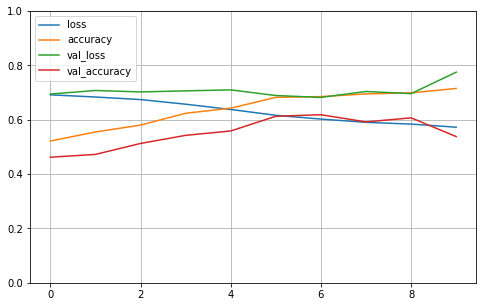

Compute valiation accuracy
2023-01-03 14:19:15.723661
Range of scores: 0.030972786 to 0.9970542
Predicted zeros and ones 298 572
Accuracy: 53.79% Precision: 44.58% Recall: 75.00% F1: 55.92%
2023-01-03 14:19:15.978669
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (3245, 4997) (3245, 1)
Valid sizes (867, 4997) (867, 1)
Train set ones/size 1513 / 3245
Valid set ones/size 389 / 867
BUILD MODEL
COMPILE
FIT
2023-01-03 14:19:17.192812
Epoch 1/10
102/102 [==============================] - 2s 11ms/step - loss: 0.6912 - accuracy: 0.5270 - val_loss: 0.6873 - val_accuracy: 0.5513
Epoch 2/10
102/102 [==============================] - 1s 9ms/step - loss: 0.6905 - accuracy: 0.5337 - val_loss: 0.6881 - val_accuracy: 0.5513
Epoch 3/10
102/102 [==============================] - 1s 9ms/step - loss: 0.6869 - accuracy: 0.5393 - val_loss: 0.6771 - val_accuracy: 0.5513
Epoch 4/10
102/102 [==============================] - 1s 9ms/step - loss: 0.6769 - accuracy: 0.5698 - val_loss: 0.6609 - 

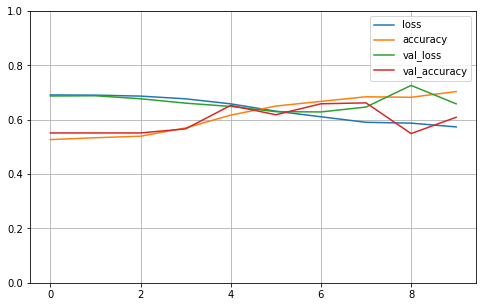

Compute valiation accuracy
2023-01-03 14:19:27.672025
Range of scores: 0.01403308 to 0.9477981
Predicted zeros and ones 599 268
Accuracy: 60.90% Precision: 59.33% Recall: 40.87% F1: 48.40%
2023-01-03 14:19:27.920521

Cross validation 5 folds 10 epochs
 accuracy mean 52.58% +/- 8.50
 precision mean 51.03% +/- 9.08
 recall mean 52.00% +/- 18.26
 F1 mean 47.84% +/- 7.40
2023-01-03 14:19:27.922017
-------------
2023-01-03 14:19:27.922073
Cell line for today: 5 = HUVEC
Load RCI values...
Num RCI: 1488
Load genes...
2023-01-03 14:19:27.933447
Load sequence...
2023-01-03 14:19:35.630653
Num IDs: 5487
Count 1579 ones out of 5487 labels.
Num counts: 5487
2023-01-03 14:19:35.633463
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
Train sizes (4419, 4997) (4419, 1)
Valid sizes (1068, 4997) (1068, 1)
Train set ones/size 1252 / 4419
Valid set ones/size 327 / 1068
BUILD MODEL
COMPILE
FIT
2023-01-03 14:19:37.341806
Epoch 1/10
139/139 [==============================] - 2s 10ms/step - lo

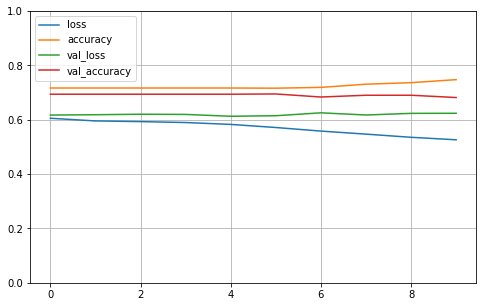

Compute valiation accuracy
2023-01-03 14:19:50.695531
Range of scores: 0.022494413 to 0.95572394
Predicted zeros and ones 997 71
Accuracy: 68.16% Precision: 40.85% Recall: 8.87% F1: 14.57%
2023-01-03 14:19:50.946449
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (4229, 4997) (4229, 1)
Valid sizes (1258, 4997) (1258, 1)
Train set ones/size 1210 / 4229
Valid set ones/size 369 / 1258
BUILD MODEL
COMPILE
FIT
2023-01-03 14:19:52.564202
Epoch 1/10
133/133 [==============================] - 2s 11ms/step - loss: 0.6116 - accuracy: 0.7113 - val_loss: 0.6052 - val_accuracy: 0.7067
Epoch 2/10
133/133 [==============================] - 1s 9ms/step - loss: 0.5986 - accuracy: 0.7139 - val_loss: 0.6043 - val_accuracy: 0.7067
Epoch 3/10
133/133 [==============================] - 1s 9ms/step - loss: 0.5978 - accuracy: 0.7139 - val_loss: 0.6035 - val_accuracy: 0.7067
Epoch 4/10
133/133 [==============================] - 1s 9ms/step - loss: 0.5949 - accuracy: 0.7139 - val_loss: 0.6048 

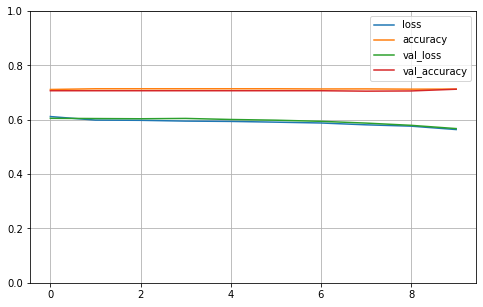

Compute valiation accuracy
2023-01-03 14:20:05.561379
Range of scores: 0.019773282 to 0.6624863
Predicted zeros and ones 1237 21
Accuracy: 71.22% Precision: 66.67% Recall: 3.79% F1: 7.18%
2023-01-03 14:20:05.818280
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (4296, 4997) (4296, 1)
Valid sizes (1191, 4997) (1191, 1)
Train set ones/size 1289 / 4296
Valid set ones/size 290 / 1191
BUILD MODEL
COMPILE
FIT
2023-01-03 14:20:07.395615
Epoch 1/10
135/135 [==============================] - 2s 10ms/step - loss: 0.6206 - accuracy: 0.7000 - val_loss: 0.5603 - val_accuracy: 0.7565
Epoch 2/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6098 - accuracy: 0.7000 - val_loss: 0.5700 - val_accuracy: 0.7565
Epoch 3/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6084 - accuracy: 0.7000 - val_loss: 0.5577 - val_accuracy: 0.7565
Epoch 4/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6054 - accuracy: 0.7000 - val_loss: 0.5597 -

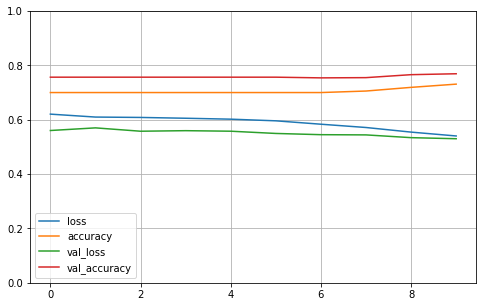

Compute valiation accuracy
2023-01-03 14:20:20.392677
Range of scores: 0.023687106 to 0.84250176
Predicted zeros and ones 1132 59
Accuracy: 76.91% Precision: 62.71% Recall: 12.76% F1: 21.20%
2023-01-03 14:20:20.614191
Fold 4
Training example
[211  74  38 ...   0   0   0]
Train sizes (4456, 4997) (4456, 1)
Valid sizes (1031, 4997) (1031, 1)
Train set ones/size 1319 / 4456
Valid set ones/size 260 / 1031
BUILD MODEL
COMPILE
FIT
2023-01-03 14:20:22.240836
Epoch 1/10
140/140 [==============================] - 2s 11ms/step - loss: 0.6137 - accuracy: 0.7009 - val_loss: 0.5732 - val_accuracy: 0.7478
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.6056 - accuracy: 0.7040 - val_loss: 0.5721 - val_accuracy: 0.7478
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.6031 - accuracy: 0.7040 - val_loss: 0.5755 - val_accuracy: 0.7478
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.5990 - accuracy: 0.7040 - val_loss: 0.574

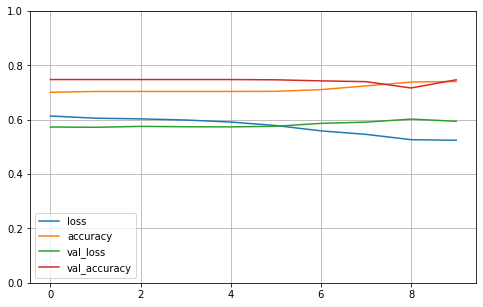

Compute valiation accuracy
2023-01-03 14:20:43.470937
Range of scores: 0.01651682 to 0.9410751
Predicted zeros and ones 980 51
Accuracy: 74.68% Precision: 49.02% Recall: 9.62% F1: 16.08%
2023-01-03 14:20:43.676219
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (4548, 4997) (4548, 1)
Valid sizes (939, 4997) (939, 1)
Train set ones/size 1246 / 4548
Valid set ones/size 333 / 939
BUILD MODEL
COMPILE
FIT
2023-01-03 14:20:45.308885
Epoch 1/10
143/143 [==============================] - 2s 10ms/step - loss: 0.5980 - accuracy: 0.7260 - val_loss: 0.6631 - val_accuracy: 0.6454
Epoch 2/10
143/143 [==============================] - 1s 9ms/step - loss: 0.5860 - accuracy: 0.7260 - val_loss: 0.6584 - val_accuracy: 0.6454
Epoch 3/10
143/143 [==============================] - 1s 9ms/step - loss: 0.5844 - accuracy: 0.7260 - val_loss: 0.6746 - val_accuracy: 0.6454
Epoch 4/10
143/143 [==============================] - 1s 9ms/step - loss: 0.5826 - accuracy: 0.7260 - val_loss: 0.6644 - val

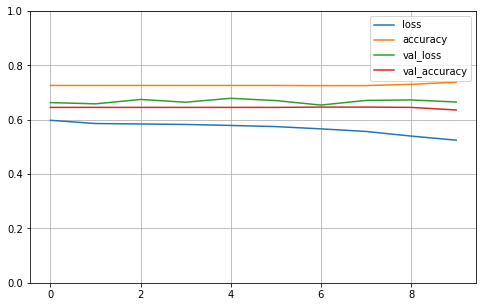

Compute valiation accuracy
2023-01-03 14:21:06.600548
Range of scores: 0.030463574 to 0.89715326
Predicted zeros and ones 866 73
Accuracy: 63.58% Precision: 43.84% Recall: 9.61% F1: 15.76%
2023-01-03 14:21:06.886108

Cross validation 5 folds 10 epochs
 accuracy mean 70.91% +/- 4.73
 precision mean 52.62% +/- 10.28
 recall mean 8.93% +/- 2.90
 F1 mean 14.96% +/- 4.51
2023-01-03 14:21:06.892420
-------------
2023-01-03 14:21:06.893340
Cell line for today: 6 = MCF.7
Load RCI values...
Num RCI: 2156
Load genes...
2023-01-03 14:21:06.910386
Load sequence...
2023-01-03 14:21:17.078788
Num IDs: 6245
Count 1828 ones out of 6245 labels.
Num counts: 6245
2023-01-03 14:21:17.081458
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
Train sizes (4988, 4997) (4988, 1)
Valid sizes (1257, 4997) (1257, 1)
Train set ones/size 1538 / 4988
Valid set ones/size 290 / 1257
BUILD MODEL
COMPILE
FIT
2023-01-03 14:21:19.074287
Epoch 1/10
156/156 [==============================] - 2s 10ms/step - los

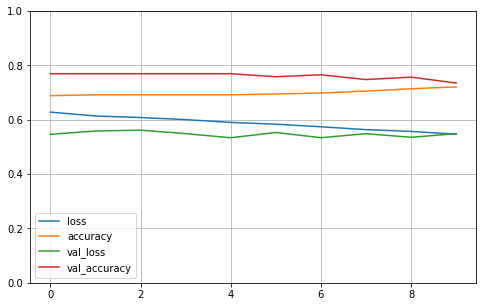

Compute valiation accuracy
2023-01-03 14:21:40.328218
Range of scores: 0.0051626465 to 0.9363522
Predicted zeros and ones 1082 175
Accuracy: 73.51% Precision: 37.71% Recall: 22.76% F1: 28.39%
2023-01-03 14:21:40.582456
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (4955, 4997) (4955, 1)
Valid sizes (1290, 4997) (1290, 1)
Train set ones/size 1479 / 4955
Valid set ones/size 349 / 1290
BUILD MODEL
COMPILE
FIT
2023-01-03 14:21:42.412776
Epoch 1/10
155/155 [==============================] - 2s 12ms/step - loss: 0.6182 - accuracy: 0.7015 - val_loss: 0.5856 - val_accuracy: 0.7295
Epoch 2/10
155/155 [==============================] - 1s 9ms/step - loss: 0.6054 - accuracy: 0.7015 - val_loss: 0.5843 - val_accuracy: 0.7295
Epoch 3/10
155/155 [==============================] - 1s 9ms/step - loss: 0.5988 - accuracy: 0.7015 - val_loss: 0.5839 - val_accuracy: 0.7295
Epoch 4/10
155/155 [==============================] - 1s 9ms/step - loss: 0.5894 - accuracy: 0.7015 - val_loss: 0.59

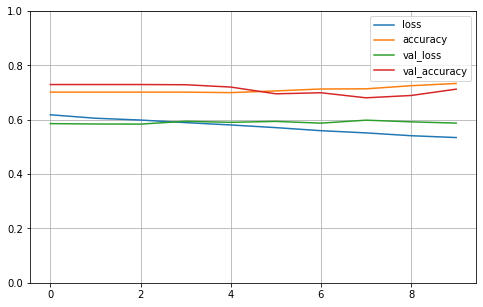

Compute valiation accuracy
2023-01-03 14:21:57.595143
Range of scores: 0.0063769594 to 0.9279979
Predicted zeros and ones 1220 70
Accuracy: 71.24% Precision: 34.29% Recall: 6.88% F1: 11.46%
2023-01-03 14:21:57.854678
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (4822, 4997) (4822, 1)
Valid sizes (1423, 4997) (1423, 1)
Train set ones/size 1355 / 4822
Valid set ones/size 473 / 1423
BUILD MODEL
COMPILE
FIT
2023-01-03 14:21:59.670127
Epoch 1/10
151/151 [==============================] - 2s 12ms/step - loss: 0.6017 - accuracy: 0.7186 - val_loss: 0.6413 - val_accuracy: 0.6676
Epoch 2/10
151/151 [==============================] - 2s 10ms/step - loss: 0.5920 - accuracy: 0.7190 - val_loss: 0.6315 - val_accuracy: 0.6676
Epoch 3/10
151/151 [==============================] - 1s 10ms/step - loss: 0.5877 - accuracy: 0.7190 - val_loss: 0.6262 - val_accuracy: 0.6676
Epoch 4/10
151/151 [==============================] - 1s 9ms/step - loss: 0.5842 - accuracy: 0.7190 - val_loss: 0.63

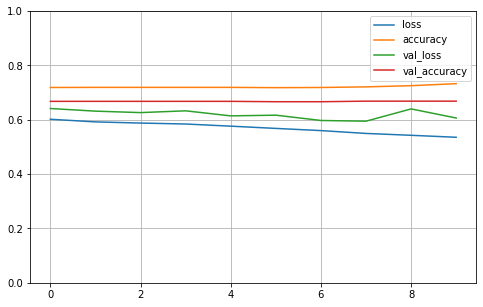

Compute valiation accuracy
2023-01-03 14:22:15.033720
Range of scores: 0.004064899 to 0.7869532
Predicted zeros and ones 1376 47
Accuracy: 66.83% Precision: 51.06% Recall: 5.07% F1: 9.23%
2023-01-03 14:22:15.268661
Fold 4
Training example
[149  84  80 ...   0   0   0]
Train sizes (5183, 4997) (5183, 1)
Valid sizes (1062, 4997) (1062, 1)
Train set ones/size 1536 / 5183
Valid set ones/size 292 / 1062
BUILD MODEL
COMPILE
FIT
2023-01-03 14:22:17.093837
Epoch 1/10
162/162 [==============================] - 2s 11ms/step - loss: 0.6164 - accuracy: 0.7036 - val_loss: 0.5888 - val_accuracy: 0.7250
Epoch 2/10
162/162 [==============================] - 1s 9ms/step - loss: 0.6036 - accuracy: 0.7036 - val_loss: 0.5882 - val_accuracy: 0.7250
Epoch 3/10
162/162 [==============================] - 1s 9ms/step - loss: 0.5962 - accuracy: 0.7036 - val_loss: 0.5844 - val_accuracy: 0.7250
Epoch 4/10
162/162 [==============================] - 1s 9ms/step - loss: 0.5871 - accuracy: 0.7031 - val_loss: 0.5955 -

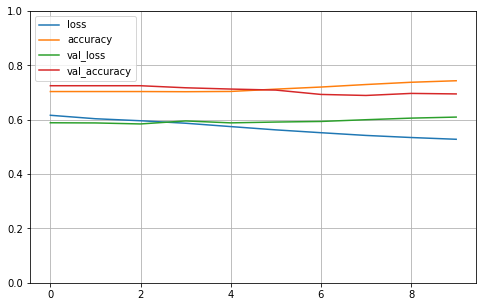

Compute valiation accuracy
2023-01-03 14:22:38.334809
Range of scores: 0.007432653 to 0.9307744
Predicted zeros and ones 1002 60
Accuracy: 69.49% Precision: 23.33% Recall: 4.79% F1: 7.95%
2023-01-03 14:22:38.605305
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (5032, 4997) (5032, 1)
Valid sizes (1213, 4997) (1213, 1)
Train set ones/size 1404 / 5032
Valid set ones/size 424 / 1213
BUILD MODEL
COMPILE
FIT
2023-01-03 14:22:40.436331
Epoch 1/10
158/158 [==============================] - 2s 10ms/step - loss: 0.6050 - accuracy: 0.7182 - val_loss: 0.6550 - val_accuracy: 0.6505
Epoch 2/10
158/158 [==============================] - 1s 9ms/step - loss: 0.5899 - accuracy: 0.7210 - val_loss: 0.6496 - val_accuracy: 0.6505
Epoch 3/10
158/158 [==============================] - 1s 9ms/step - loss: 0.5823 - accuracy: 0.7210 - val_loss: 0.6266 - val_accuracy: 0.6505
Epoch 4/10
158/158 [==============================] - 1s 9ms/step - loss: 0.5738 - accuracy: 0.7210 - val_loss: 0.6097 -

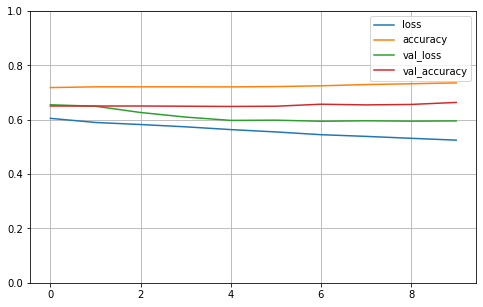

Compute valiation accuracy
2023-01-03 14:23:01.661751
Range of scores: 0.007894542 to 0.90979046
Predicted zeros and ones 1115 98
Accuracy: 66.36% Precision: 58.16% Recall: 13.44% F1: 21.84%
2023-01-03 14:23:01.913753

Cross validation 5 folds 10 epochs
 accuracy mean 69.49% +/- 2.69
 precision mean 40.91% +/- 12.36
 recall mean 10.59% +/- 6.84
 F1 mean 15.77% +/- 7.98
2023-01-03 14:23:01.917819
-------------
2023-01-03 14:23:01.917889
Cell line for today: 7 = NCI.H460
Load RCI values...
Num RCI: 610
Load genes...
2023-01-03 14:23:01.929200
Load sequence...
2023-01-03 14:23:06.274430
Num IDs: 3057
Count 709 ones out of 3057 labels.
Num counts: 3057
2023-01-03 14:23:06.276915
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (2364, 4997) (2364, 1)
Valid sizes (693, 4997) (693, 1)
Train set ones/size 603 / 2364
Valid set ones/size 106 / 693
BUILD MODEL
COMPILE
FIT
2023-01-03 14:23:07.375154
Epoch 1/10
74/74 [==============================] - 2s 13ms/step - loss:

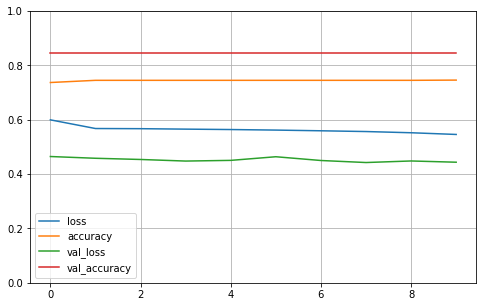

Compute valiation accuracy
2023-01-03 14:23:18.426738
Range of scores: 0.11914012 to 0.34827203
Predicted zeros and ones 693 0
Accuracy: 84.70% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:23:18.680449
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[117 210  72 ...   0   0   0]
Train sizes (2503, 4997) (2503, 1)
Valid sizes (554, 4997) (554, 1)
Train set ones/size 568 / 2503
Valid set ones/size 141 / 554
BUILD MODEL
COMPILE
FIT
2023-01-03 14:23:19.601501
Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 0.5739 - accuracy: 0.7727 - val_loss: 0.5736 - val_accuracy: 0.7455
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.5350 - accuracy: 0.7731 - val_loss: 0.5694 - val_accuracy: 0.7455
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.5333 - accuracy: 0.7731 - val_loss: 0.5694 - val_accuracy: 0.7455
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.5315 - accuracy: 0.7731 - val_loss: 0.5736 - val_accuracy: 0.7455
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.5317 - accuracy: 0.7731 - val_loss: 0.5770 - val_accuracy: 0.7455
Epoch 6/10
79/79 [==============================] - 1s 10ms/step - loss

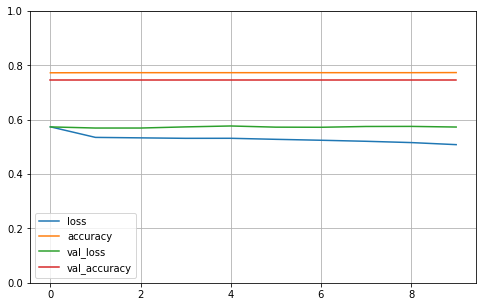

Compute valiation accuracy
2023-01-03 14:23:27.955438
Range of scores: 0.19067502 to 0.40124947
Predicted zeros and ones 554 0
Accuracy: 74.55% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:23:28.120867
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (2434, 4997) (2434, 1)
Valid sizes (623, 4997) (623, 1)
Train set ones/size 648 / 2434
Valid set ones/size 61 / 623
BUILD MODEL
COMPILE
FIT
2023-01-03 14:23:29.030734
Epoch 1/10
77/77 [==============================] - 2s 13ms/step - loss: 0.6118 - accuracy: 0.7251 - val_loss: 0.4314 - val_accuracy: 0.9021
Epoch 2/10
77/77 [==============================] - 1s 10ms/step - loss: 0.5792 - accuracy: 0.7338 - val_loss: 0.4239 - val_accuracy: 0.9021
Epoch 3/10
77/77 [==============================] - 1s 9ms/step - loss: 0.5779 - accuracy: 0.7338 - val_loss: 0.3992 - val_accuracy: 0.9021
Epoch 4/10
77/77 [==============================] - 1s 10ms/step - loss: 0.5761 - accuracy: 0.7338 - val_loss: 0.4002 - val_accuracy: 0.9021
Epoch 5/10
77/77 [==============================] - 1s 10ms/step - loss: 0.5764 - accuracy: 0.7338 - val_loss: 0.4041 - val_accuracy: 0.9021
Epoch 6/10
77/77 [==============================] - 1s 10ms/step - los

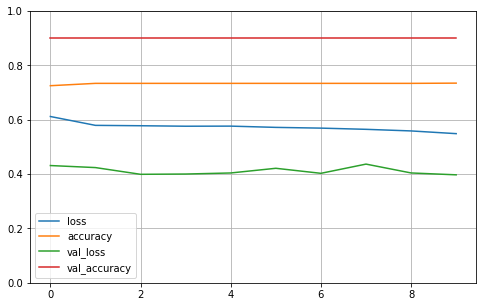

Compute valiation accuracy
2023-01-03 14:23:40.340971
Range of scores: 0.15248163 to 0.44021806
Predicted zeros and ones 623 0
Accuracy: 90.21% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:23:40.583798
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (2523, 4997) (2523, 1)
Valid sizes (534, 4997) (534, 1)
Train set ones/size 478 / 2523
Valid set ones/size 231 / 534
BUILD MODEL
COMPILE
FIT
2023-01-03 14:23:41.533172
Epoch 1/10
79/79 [==============================] - 1s 12ms/step - loss: 0.5360 - accuracy: 0.8002 - val_loss: 0.8642 - val_accuracy: 0.5674
Epoch 2/10
79/79 [==============================] - 1s 9ms/step - loss: 0.4827 - accuracy: 0.8105 - val_loss: 0.8857 - val_accuracy: 0.5674
Epoch 3/10
79/79 [==============================] - 1s 9ms/step - loss: 0.4817 - accuracy: 0.8105 - val_loss: 0.8596 - val_accuracy: 0.5674
Epoch 4/10
79/79 [==============================] - 1s 9ms/step - loss: 0.4792 - accuracy: 0.8105 - val_loss: 0.8356 - val_accuracy: 0.5674
Epoch 5/10
79/79 [==============================] - 1s 9ms/step - loss: 0.4770 - accuracy: 0.8105 - val_loss: 0.8225 - val_accuracy: 0.5674
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 

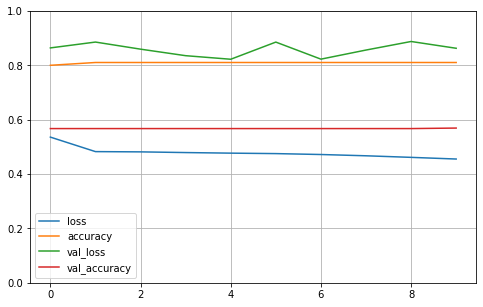

Compute valiation accuracy
2023-01-03 14:23:52.517568
Range of scores: 0.080637366 to 0.5261137
Predicted zeros and ones 533 1
Accuracy: 56.93% Precision: 100.00% Recall: 0.43% F1: 0.86%
2023-01-03 14:23:52.671619
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (2404, 4997) (2404, 1)
Valid sizes (653, 4997) (653, 1)
Train set ones/size 539 / 2404
Valid set ones/size 170 / 653
BUILD MODEL
COMPILE
FIT
2023-01-03 14:23:53.601448
Epoch 1/10
76/76 [==============================] - 2s 13ms/step - loss: 0.5670 - accuracy: 0.7675 - val_loss: 0.5834 - val_accuracy: 0.7397
Epoch 2/10
76/76 [==============================] - 1s 9ms/step - loss: 0.5324 - accuracy: 0.7758 - val_loss: 0.5754 - val_accuracy: 0.7397
Epoch 3/10
76/76 [==============================] - 1s 10ms/step - loss: 0.5309 - accuracy: 0.7758 - val_loss: 0.5824 - val_accuracy: 0.7397
Epoch 4/10
76/76 [==============================] - 1s 10ms/step - loss: 0.5308 - accuracy: 0.7758 - val_loss: 0.5741 - val_accura

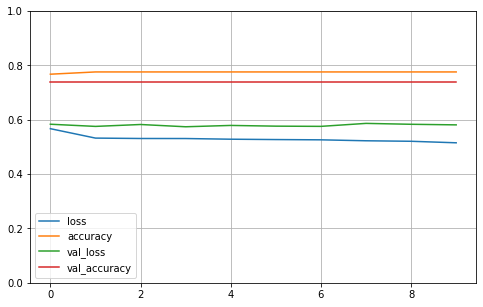

Compute valiation accuracy
2023-01-03 14:24:04.581586
Range of scores: 0.11760902 to 0.2471691
Predicted zeros and ones 653 0
Accuracy: 73.97% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:24:04.829256

Cross validation 5 folds 10 epochs
 accuracy mean 76.07% +/- 11.38
 precision mean 20.00% +/- 40.00
 recall mean 0.09% +/- 0.17
 F1 mean 0.17% +/- 0.34
2023-01-03 14:24:04.830496
-------------
2023-01-03 14:24:04.830552
Cell line for today: 8 = NHEK
Load RCI values...
Num RCI: 1080
Load genes...
2023-01-03 14:24:04.843097
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 14:24:11.434445
Num IDs: 4679
Count 1673 ones out of 4679 labels.
Num counts: 4679
2023-01-03 14:24:11.497813
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (3644, 4997) (3644, 1)
Valid sizes (1035, 4997) (1035, 1)
Train set ones/size 1277 / 3644
Valid set ones/size 396 / 1035
BUILD MODEL
COMPILE
FIT
2023-01-03 14:24:12.870208
Epoch 1/10
114/114 [==============================] - 2s 11ms/step - loss: 0.6540 - accuracy: 0.6474 - val_loss: 0.6649 - val_accuracy: 0.6174
Epoch 2/10
114/114 [==============================] - 1s 9ms/step - loss: 0.6413 - accuracy: 0.6496 - val_loss: 0.6596 - val_accuracy: 0.6174
Epoch 3/10
114/114 [==============================] - 1s 9ms/step - loss: 0.6316 - accuracy: 0.6496 - val_loss: 0.6635 - val_accuracy: 0.6174
Epoch 4/10
114/114 [==============================] - 1s 9ms/step - loss: 0.6211 - accuracy: 0.6570 - val_loss: 0.6498 - val_accuracy: 0.6164
Epoch 5/10
114/114 [==============================] - 1s 9ms/s

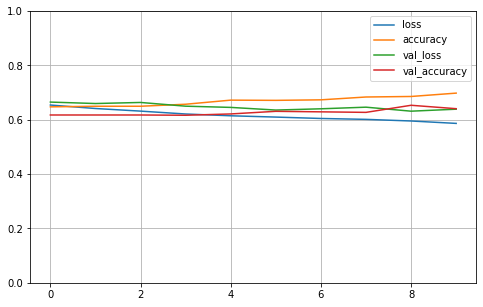

Compute valiation accuracy
2023-01-03 14:24:24.625687
Range of scores: 0.012316125 to 0.72944975
Predicted zeros and ones 997 38
Accuracy: 64.06% Precision: 81.58% Recall: 7.83% F1: 14.29%
2023-01-03 14:24:24.877077
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (3906, 4997) (3906, 1)
Valid sizes (773, 4997) (773, 1)
Train set ones/size 1449 / 3906
Valid set ones/size 224 / 773
BUILD MODEL
COMPILE
FIT
2023-01-03 14:24:26.233378
Epoch 1/10
123/123 [==============================] - 2s 11ms/step - loss: 0.6620 - accuracy: 0.6270 - val_loss: 0.6193 - val_accuracy: 0.7102
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 0.6527 - accuracy: 0.6290 - val_loss: 0.5976 - val_accuracy: 0.7102
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 0.6401 - accuracy: 0.6354 - val_loss: 0.5921 - val_accuracy: 0.7076
Epoch 4/10
123/123 [==============================] - 1s 10ms/step - loss: 0.6259 - accuracy: 0.6467 - val_loss: 0.5933 - 

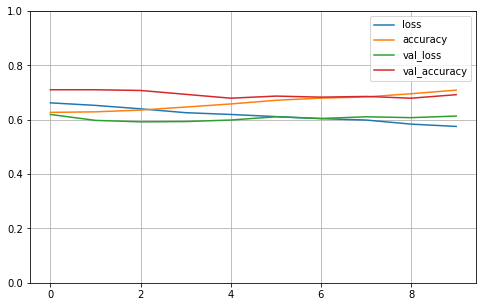

Compute valiation accuracy
2023-01-03 14:24:38.743736
Range of scores: 0.011098966 to 0.93997556
Predicted zeros and ones 667 106
Accuracy: 69.21% Precision: 43.40% Recall: 20.54% F1: 27.88%
2023-01-03 14:24:38.990193
Fold 3
Training example
[22 88 94 ...  0  0  0]
Train sizes (3517, 4997) (3517, 1)
Valid sizes (1162, 4997) (1162, 1)
Train set ones/size 1144 / 3517
Valid set ones/size 529 / 1162
BUILD MODEL
COMPILE
FIT
2023-01-03 14:24:40.396108
Epoch 1/10
110/110 [==============================] - 2s 11ms/step - loss: 0.6412 - accuracy: 0.6707 - val_loss: 0.7112 - val_accuracy: 0.5448
Epoch 2/10
110/110 [==============================] - 1s 9ms/step - loss: 0.6299 - accuracy: 0.6747 - val_loss: 0.7262 - val_accuracy: 0.5448
Epoch 3/10
110/110 [==============================] - 1s 9ms/step - loss: 0.6275 - accuracy: 0.6747 - val_loss: 0.7074 - val_accuracy: 0.5448
Epoch 4/10
110/110 [==============================] - 1s 10ms/step - loss: 0.6246 - accuracy: 0.6747 - val_loss: 0.6983 - v

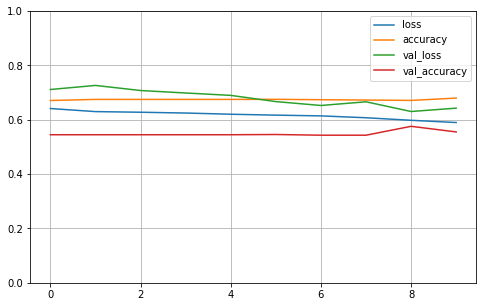

Compute valiation accuracy
2023-01-03 14:25:01.622885
Range of scores: 0.03949963 to 0.728555
Predicted zeros and ones 1120 42
Accuracy: 55.51% Precision: 64.29% Recall: 5.10% F1: 9.46%
2023-01-03 14:25:01.841489
Fold 4
Training example
[211  74  38 ...   0   0   0]
Train sizes (3887, 4997) (3887, 1)
Valid sizes (792, 4997) (792, 1)
Train set ones/size 1427 / 3887
Valid set ones/size 246 / 792
BUILD MODEL
COMPILE
FIT
2023-01-03 14:25:03.235621
Epoch 1/10
122/122 [==============================] - 2s 11ms/step - loss: 0.6609 - accuracy: 0.6329 - val_loss: 0.6244 - val_accuracy: 0.6894
Epoch 2/10
122/122 [==============================] - 1s 9ms/step - loss: 0.6490 - accuracy: 0.6329 - val_loss: 0.6247 - val_accuracy: 0.6894
Epoch 3/10
122/122 [==============================] - 1s 9ms/step - loss: 0.6303 - accuracy: 0.6383 - val_loss: 0.6339 - val_accuracy: 0.6641
Epoch 4/10
122/122 [==============================] - 1s 9ms/step - loss: 0.6158 - accuracy: 0.6565 - val_loss: 0.6401 - val_

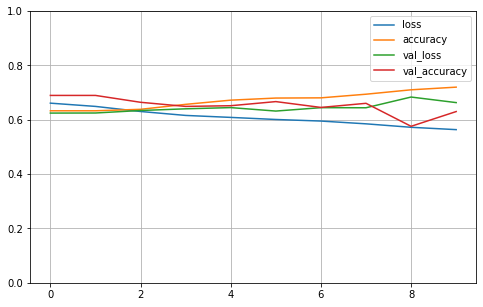

Compute valiation accuracy
2023-01-03 14:25:15.358526
Range of scores: 0.016354267 to 0.9055422
Predicted zeros and ones 613 179
Accuracy: 63.01% Precision: 36.87% Recall: 26.83% F1: 31.06%
2023-01-03 14:25:15.618814
Fold 5
Training example
[211  74  38 ...   0   0   0]
Train sizes (3762, 4997) (3762, 1)
Valid sizes (917, 4997) (917, 1)
Train set ones/size 1395 / 3762
Valid set ones/size 278 / 917
BUILD MODEL
COMPILE
FIT
2023-01-03 14:25:16.995585
Epoch 1/10
118/118 [==============================] - 2s 11ms/step - loss: 0.6624 - accuracy: 0.6292 - val_loss: 0.6223 - val_accuracy: 0.6968
Epoch 2/10
118/118 [==============================] - 1s 9ms/step - loss: 0.6505 - accuracy: 0.6292 - val_loss: 0.6280 - val_accuracy: 0.6968
Epoch 3/10
118/118 [==============================] - 1s 9ms/step - loss: 0.6300 - accuracy: 0.6353 - val_loss: 0.6486 - val_accuracy: 0.6401
Epoch 4/10
118/118 [==============================] - 1s 9ms/step - loss: 0.6099 - accuracy: 0.6669 - val_loss: 0.6865 - 

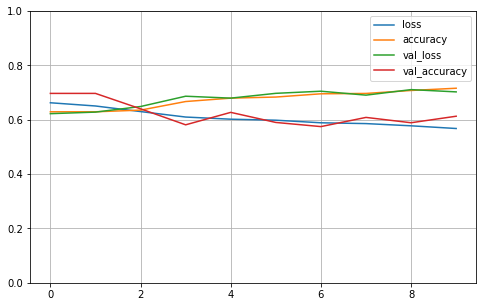

Compute valiation accuracy
2023-01-03 14:25:38.178233
Range of scores: 0.0055792956 to 0.9667497
Predicted zeros and ones 726 191
Accuracy: 61.29% Precision: 29.84% Recall: 20.50% F1: 24.31%
2023-01-03 14:25:38.420838

Cross validation 5 folds 10 epochs
 accuracy mean 62.61% +/- 4.43
 precision mean 51.20% +/- 19.06
 recall mean 16.16% +/- 8.29
 F1 mean 21.40% +/- 8.21
2023-01-03 14:25:38.425100
-------------
2023-01-03 14:25:38.425155
Cell line for today: 9 = SK.MEL.5
Load RCI values...
Num RCI: 534
Load genes...
2023-01-03 14:25:38.437242
Load sequence...
2023-01-03 14:25:42.693942
Num IDs: 3003
Count 678 ones out of 3003 labels.
Num counts: 3003
2023-01-03 14:25:42.696677
splitting
Fold 1
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2416, 4997) (2416, 1)
Valid sizes (587, 4997) (587, 1)
Train set ones/size 531 / 2416
Valid set ones/size 147 / 587
BUILD MODEL
COMPILE
FIT
2023-01-03 14:25:43.690262
Epoch 1/10
76/76 [==============================] - 2s 14ms/step - loss:

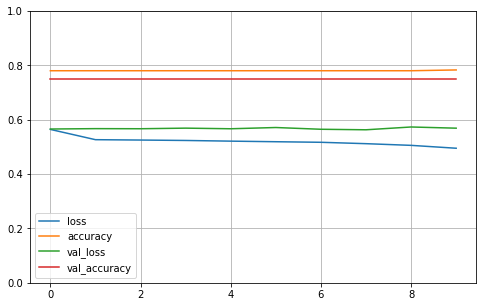

Compute valiation accuracy
2023-01-03 14:25:55.117042
Range of scores: 0.060385 to 0.4516286
Predicted zeros and ones 587 0
Accuracy: 74.96% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:25:55.284495
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 228 142 ...   0   0   0]
Train sizes (2251, 4997) (2251, 1)
Valid sizes (752, 4997) (752, 1)
Train set ones/size 563 / 2251
Valid set ones/size 115 / 752
BUILD MODEL
COMPILE
FIT
2023-01-03 14:25:56.223781
Epoch 1/10
71/71 [==============================] - 1s 14ms/step - loss: 0.5989 - accuracy: 0.7499 - val_loss: 0.4682 - val_accuracy: 0.8471
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.5626 - accuracy: 0.7499 - val_loss: 0.4642 - val_accuracy: 0.8471
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.5611 - accuracy: 0.7499 - val_loss: 0.4550 - val_accuracy: 0.8471
Epoch 4/10
71/71 [==============================] - 1s 10ms/step - loss: 0.5587 - accuracy: 0.7499 - val_loss: 0.4666 - val_accuracy: 0.8471
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.5573 - accuracy: 0.7499 - val_loss: 0.4659 - val_accuracy: 0.8471
Epoch 6/10
71/71 [==============================] - 1s 9ms/step - loss

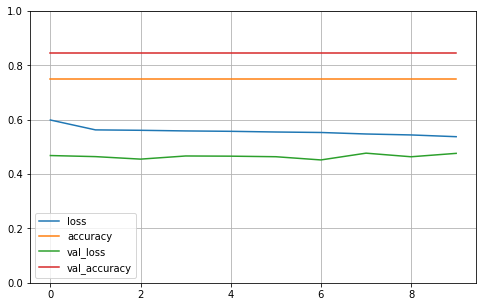

Compute valiation accuracy
2023-01-03 14:26:04.373631
Range of scores: 0.12865986 to 0.45979905
Predicted zeros and ones 752 0
Accuracy: 84.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:26:04.633370
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 228 142 ...   0   0   0]
Train sizes (2456, 4997) (2456, 1)
Valid sizes (547, 4997) (547, 1)
Train set ones/size 500 / 2456
Valid set ones/size 178 / 547
BUILD MODEL
COMPILE
FIT
2023-01-03 14:26:05.538164
Epoch 1/10
77/77 [==============================] - 1s 12ms/step - loss: 0.5602 - accuracy: 0.7879 - val_loss: 0.6910 - val_accuracy: 0.6746
Epoch 2/10
77/77 [==============================] - 1s 9ms/step - loss: 0.5056 - accuracy: 0.7964 - val_loss: 0.6737 - val_accuracy: 0.6746
Epoch 3/10
77/77 [==============================] - 1s 9ms/step - loss: 0.5037 - accuracy: 0.7964 - val_loss: 0.6674 - val_accuracy: 0.6746
Epoch 4/10
77/77 [==============================] - 1s 9ms/step - loss: 0.5032 - accuracy: 0.7964 - val_loss: 0.6841 - val_accuracy: 0.6746
Epoch 5/10
77/77 [==============================] - 1s 9ms/step - loss: 0.5023 - accuracy: 0.7964 - val_loss: 0.6695 - val_accuracy: 0.6746
Epoch 6/10
77/77 [==============================] - 1s 9ms/step - loss: 

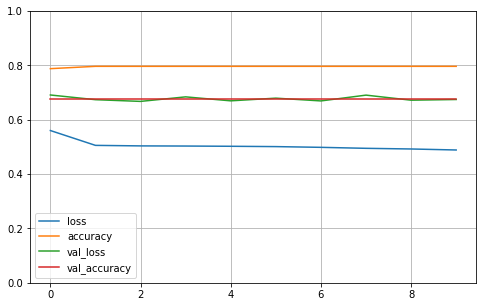

Compute valiation accuracy
2023-01-03 14:26:16.487662
Range of scores: 0.12004821 to 0.29037595
Predicted zeros and ones 547 0
Accuracy: 67.46% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:26:16.749815
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 228 142 ...   0   0   0]
Train sizes (2348, 4997) (2348, 1)
Valid sizes (655, 4997) (655, 1)
Train set ones/size 506 / 2348
Valid set ones/size 172 / 655
BUILD MODEL
COMPILE
FIT
2023-01-03 14:26:17.655121
Epoch 1/10
74/74 [==============================] - 1s 13ms/step - loss: 0.5567 - accuracy: 0.7845 - val_loss: 0.5915 - val_accuracy: 0.7374
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.5221 - accuracy: 0.7845 - val_loss: 0.5805 - val_accuracy: 0.7374
Epoch 3/10
74/74 [==============================] - 1s 9ms/step - loss: 0.5194 - accuracy: 0.7845 - val_loss: 0.5877 - val_accuracy: 0.7374
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.5182 - accuracy: 0.7845 - val_loss: 0.5818 - val_accuracy: 0.7374
Epoch 5/10
74/74 [==============================] - 1s 9ms/step - loss: 0.5160 - accuracy: 0.7845 - val_loss: 0.5776 - val_accuracy: 0.7374
Epoch 6/10
74/74 [==============================] - 1s 10ms/step - los

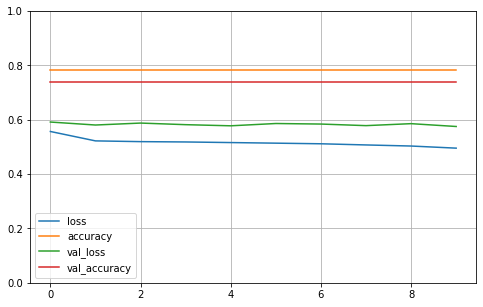

Compute valiation accuracy
2023-01-03 14:26:25.958198
Range of scores: 0.11563978 to 0.303603
Predicted zeros and ones 655 0
Accuracy: 73.74% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:26:26.127449
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 228 142 ...   0   0   0]
Train sizes (2541, 4997) (2541, 1)
Valid sizes (462, 4997) (462, 1)
Train set ones/size 612 / 2541
Valid set ones/size 66 / 462
BUILD MODEL
COMPILE
FIT
2023-01-03 14:26:27.054634
Epoch 1/10
80/80 [==============================] - 1s 11ms/step - loss: 0.5863 - accuracy: 0.7591 - val_loss: 0.4420 - val_accuracy: 0.8571
Epoch 2/10
80/80 [==============================] - 1s 9ms/step - loss: 0.5516 - accuracy: 0.7591 - val_loss: 0.4517 - val_accuracy: 0.8571
Epoch 3/10
80/80 [==============================] - 1s 9ms/step - loss: 0.5501 - accuracy: 0.7591 - val_loss: 0.4264 - val_accuracy: 0.8571
Epoch 4/10
80/80 [==============================] - 1s 9ms/step - loss: 0.5491 - accuracy: 0.7591 - val_loss: 0.4311 - val_accuracy: 0.8571
Epoch 5/10
80/80 [==============================] - 1s 9ms/step - loss: 0.5451 - accuracy: 0.7591 - val_loss: 0.4580 - val_accuracy: 0.8571
Epoch 6/10
80/80 [==============================] - 1s 9ms/step - loss: 0

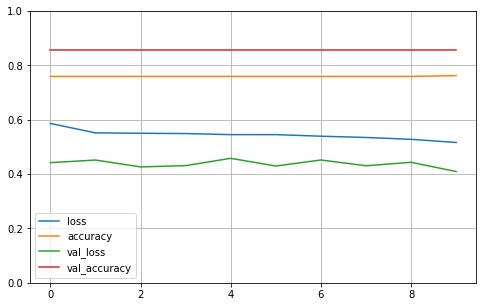

Compute valiation accuracy
2023-01-03 14:26:38.004661
Range of scores: 0.084983915 to 0.37620512
Predicted zeros and ones 462 0
Accuracy: 85.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:26:38.165559

Cross validation 5 folds 10 epochs
 accuracy mean 77.32% +/- 6.94
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 14:26:38.166436
-------------
2023-01-03 14:26:38.166492
Cell line for today: 10 = SK.N.DZ
Load RCI values...
Num RCI: 603
Load genes...
2023-01-03 14:26:38.178085
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 14:26:42.880175
Num IDs: 3324
Count 1282 ones out of 3324 labels.
Num counts: 3324
2023-01-03 14:26:42.881147
splitting
Fold 1
Training example
[117 210  72 ...   0   0   0]
Train sizes (2673, 4997) (2673, 1)
Valid sizes (651, 4997) (651, 1)
Train set ones/size 977 / 2673
Valid set ones/size 305 / 651
BUILD MODEL
COMPILE
FIT
2023-01-03 14:26:43.973329
Epoch 1/10
84/84 [==============================] - 2s 12ms/step - loss: 0.6618 - accuracy: 0.6337 - val_loss: 0.7143 - val_accuracy: 0.5315
Epoch 2/10
84/84 [==============================] - 1s 9ms/step - loss: 0.6558 - accuracy: 0.6345 - val_loss: 0.7204 - val_accuracy: 0.5315
Epoch 3/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6547 - accuracy: 0.6345 - val_loss: 0.7089 - val_accuracy: 0.5315
Epoch 4/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6524 - accuracy: 0.6345 - val_loss: 0.6973 - val_accuracy: 0.5315
Epoch 5/10
84/84 [==============================] - 1s 10ms/step - loss:

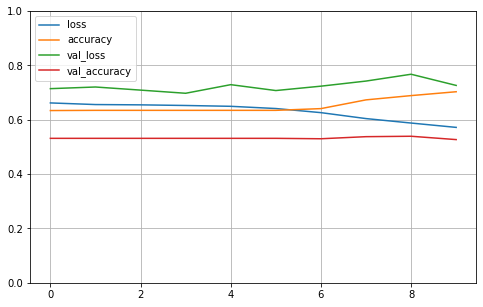

Compute valiation accuracy
2023-01-03 14:26:55.015803
Range of scores: 0.10943324 to 0.8825554
Predicted zeros and ones 548 103
Accuracy: 52.69% Precision: 48.54% Recall: 16.39% F1: 24.51%
2023-01-03 14:26:55.254144
Fold 2
Training example
[117 210  72 ...   0   0   0]
Train sizes (2542, 4997) (2542, 1)
Valid sizes (782, 4997) (782, 1)
Train set ones/size 997 / 2542
Valid set ones/size 285 / 782
BUILD MODEL
COMPILE
FIT
2023-01-03 14:26:56.234799
Epoch 1/10
80/80 [==============================] - 1s 12ms/step - loss: 0.6748 - accuracy: 0.6011 - val_loss: 0.6625 - val_accuracy: 0.6355
Epoch 2/10
80/80 [==============================] - 1s 10ms/step - loss: 0.6686 - accuracy: 0.6078 - val_loss: 0.6580 - val_accuracy: 0.6355
Epoch 3/10
80/80 [==============================] - 1s 9ms/step - loss: 0.6679 - accuracy: 0.6078 - val_loss: 0.6594 - val_accuracy: 0.6355
Epoch 4/10
80/80 [==============================] - 1s 10ms/step - loss: 0.6674 - accuracy: 0.6078 - val_loss: 0.6625 - val_accu

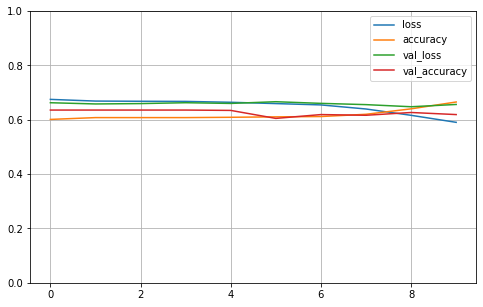

Compute valiation accuracy
2023-01-03 14:27:07.181846
Range of scores: 0.027778128 to 0.89882076
Predicted zeros and ones 649 133
Accuracy: 61.89% Precision: 45.11% Recall: 21.05% F1: 28.71%
2023-01-03 14:27:07.425499
Fold 3
Training example
[186 232 158 ...   0   0   0]
Train sizes (2645, 4997) (2645, 1)
Valid sizes (679, 4997) (679, 1)
Train set ones/size 1087 / 2645
Valid set ones/size 195 / 679
BUILD MODEL
COMPILE
FIT
2023-01-03 14:27:08.427943
Epoch 1/10
83/83 [==============================] - 2s 12ms/step - loss: 0.6789 - accuracy: 0.5860 - val_loss: 0.6191 - val_accuracy: 0.7128
Epoch 2/10
83/83 [==============================] - 1s 10ms/step - loss: 0.6775 - accuracy: 0.5890 - val_loss: 0.6265 - val_accuracy: 0.7128
Epoch 3/10
83/83 [==============================] - 1s 10ms/step - loss: 0.6758 - accuracy: 0.5890 - val_loss: 0.6387 - val_accuracy: 0.7128
Epoch 4/10
83/83 [==============================] - 1s 10ms/step - loss: 0.6716 - accuracy: 0.5890 - val_loss: 0.6186 - val_

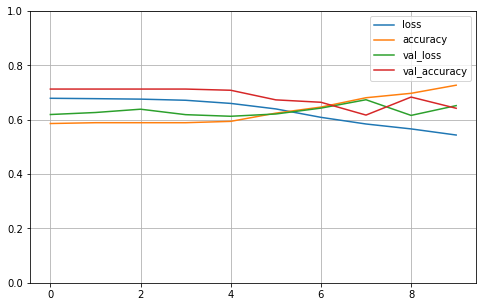

Compute valiation accuracy
2023-01-03 14:27:19.743836
Range of scores: 0.002952199 to 0.9232976
Predicted zeros and ones 539 140
Accuracy: 64.21% Precision: 32.86% Recall: 23.59% F1: 27.46%
2023-01-03 14:27:19.986414
Fold 4
Training example
[117 210  72 ...   0   0   0]
Train sizes (2735, 4997) (2735, 1)
Valid sizes (589, 4997) (589, 1)
Train set ones/size 1019 / 2735
Valid set ones/size 263 / 589
BUILD MODEL
COMPILE
FIT
2023-01-03 14:27:20.970386
Epoch 1/10
86/86 [==============================] - 2s 12ms/step - loss: 0.6635 - accuracy: 0.6274 - val_loss: 0.7023 - val_accuracy: 0.5535
Epoch 2/10
86/86 [==============================] - 1s 9ms/step - loss: 0.6598 - accuracy: 0.6274 - val_loss: 0.6953 - val_accuracy: 0.5535
Epoch 3/10
86/86 [==============================] - 1s 9ms/step - loss: 0.6584 - accuracy: 0.6274 - val_loss: 0.6899 - val_accuracy: 0.5535
Epoch 4/10
86/86 [==============================] - 1s 10ms/step - loss: 0.6564 - accuracy: 0.6274 - val_loss: 0.6986 - val_acc

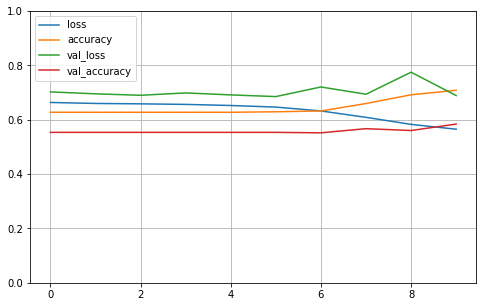

Compute valiation accuracy
2023-01-03 14:27:31.915766
Range of scores: 0.023518605 to 0.8906818
Predicted zeros and ones 427 162
Accuracy: 58.40% Precision: 55.56% Recall: 34.22% F1: 42.35%
2023-01-03 14:27:32.071457
Fold 5
Training example
[117 210  72 ...   0   0   0]
Train sizes (2701, 4997) (2701, 1)
Valid sizes (623, 4997) (623, 1)
Train set ones/size 1048 / 2701
Valid set ones/size 234 / 623
BUILD MODEL
COMPILE
FIT
2023-01-03 14:27:33.047795
Epoch 1/10
85/85 [==============================] - 2s 13ms/step - loss: 0.6733 - accuracy: 0.6083 - val_loss: 0.6633 - val_accuracy: 0.6244
Epoch 2/10
85/85 [==============================] - 1s 9ms/step - loss: 0.6677 - accuracy: 0.6120 - val_loss: 0.6625 - val_accuracy: 0.6244
Epoch 3/10
85/85 [==============================] - 1s 9ms/step - loss: 0.6658 - accuracy: 0.6120 - val_loss: 0.6624 - val_accuracy: 0.6244
Epoch 4/10
85/85 [==============================] - 1s 10ms/step - loss: 0.6640 - accuracy: 0.6120 - val_loss: 0.6620 - val_acc

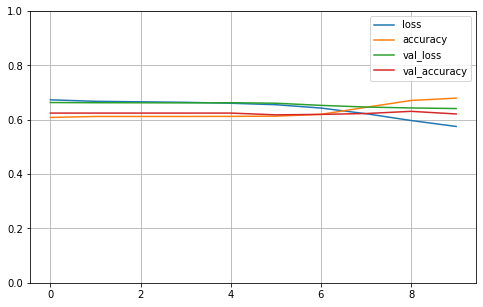

Compute valiation accuracy
2023-01-03 14:27:42.238083
Range of scores: 0.01671003 to 0.81368315
Predicted zeros and ones 579 44
Accuracy: 62.12% Precision: 47.73% Recall: 8.97% F1: 15.11%
2023-01-03 14:27:42.486163

Cross validation 5 folds 10 epochs
 accuracy mean 59.86% +/- 4.04
 precision mean 45.96% +/- 7.41
 recall mean 20.85% +/- 8.33
 F1 mean 27.63% +/- 8.77
2023-01-03 14:27:42.489968
-------------
2023-01-03 14:27:42.490052
Cell line for today: 11 = SK.N.SH
Load RCI values...
Num RCI: 1647
Load genes...
2023-01-03 14:27:42.502133
Load sequence...
2023-01-03 14:27:50.754937
Num IDs: 5800
Count 1806 ones out of 5800 labels.
Num counts: 5800
2023-01-03 14:27:50.756088
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
Train sizes (4632, 4997) (4632, 1)
Valid sizes (1168, 4997) (1168, 1)
Train set ones/size 1407 / 4632
Valid set ones/size 399 / 1168
BUILD MODEL
COMPILE
FIT
2023-01-03 14:27:52.486784
Epoch 1/10
145/145 [==============================] - 2s 11ms/step - l

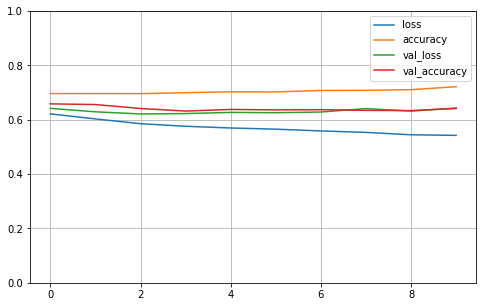

Compute valiation accuracy
2023-01-03 14:28:13.756950
Range of scores: 0.0018671047 to 0.8209916
Predicted zeros and ones 1080 88
Accuracy: 64.13% Precision: 38.64% Recall: 8.52% F1: 13.96%
2023-01-03 14:28:13.975456
Fold 2
Training example
[211  74  38 ...   0   0   0]
Train sizes (4373, 4997) (4373, 1)
Valid sizes (1427, 4997) (1427, 1)
Train set ones/size 1347 / 4373
Valid set ones/size 459 / 1427
BUILD MODEL
COMPILE
FIT
2023-01-03 14:28:15.665318
Epoch 1/10
137/137 [==============================] - 2s 12ms/step - loss: 0.6219 - accuracy: 0.6906 - val_loss: 0.6230 - val_accuracy: 0.6783
Epoch 2/10
137/137 [==============================] - 1s 10ms/step - loss: 0.6097 - accuracy: 0.6920 - val_loss: 0.6131 - val_accuracy: 0.6783
Epoch 3/10
137/137 [==============================] - 1s 10ms/step - loss: 0.5983 - accuracy: 0.6899 - val_loss: 0.6097 - val_accuracy: 0.7036
Epoch 4/10
137/137 [==============================] - 1s 9ms/step - loss: 0.5918 - accuracy: 0.6856 - val_loss: 0.59

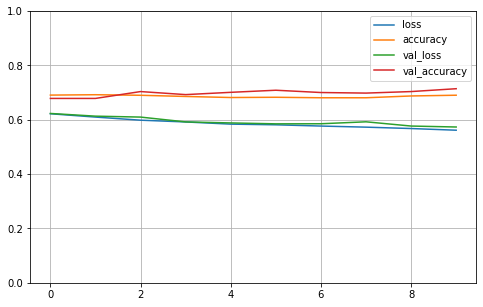

Compute valiation accuracy
2023-01-03 14:28:30.410264
Range of scores: 0.01403004 to 0.9206547
Predicted zeros and ones 1246 181
Accuracy: 71.41% Precision: 64.09% Recall: 25.27% F1: 36.25%
2023-01-03 14:28:30.656120
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (4570, 4997) (4570, 1)
Valid sizes (1230, 4997) (1230, 1)
Train set ones/size 1519 / 4570
Valid set ones/size 287 / 1230
BUILD MODEL
COMPILE
FIT
2023-01-03 14:28:32.410100
Epoch 1/10
143/143 [==============================] - 2s 11ms/step - loss: 0.6390 - accuracy: 0.6650 - val_loss: 0.5528 - val_accuracy: 0.7667
Epoch 2/10
143/143 [==============================] - 1s 9ms/step - loss: 0.6258 - accuracy: 0.6676 - val_loss: 0.5720 - val_accuracy: 0.7659
Epoch 3/10
143/143 [==============================] - 1s 9ms/step - loss: 0.6112 - accuracy: 0.6661 - val_loss: 0.5454 - val_accuracy: 0.7520
Epoch 4/10
143/143 [==============================] - 1s 9ms/step - loss: 0.5969 - accuracy: 0.6711 - val_loss: 0.5567

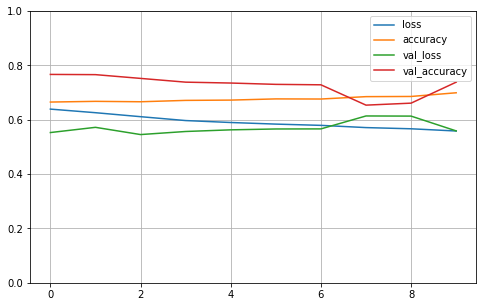

Compute valiation accuracy
2023-01-03 14:28:47.243844
Range of scores: 0.0014838821 to 0.8738656
Predicted zeros and ones 1161 69
Accuracy: 73.82% Precision: 24.64% Recall: 5.92% F1: 9.55%
2023-01-03 14:28:47.471444
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (4756, 4997) (4756, 1)
Valid sizes (1044, 4997) (1044, 1)
Train set ones/size 1470 / 4756
Valid set ones/size 336 / 1044
BUILD MODEL
COMPILE
FIT
2023-01-03 14:28:49.158143
Epoch 1/10
149/149 [==============================] - 2s 11ms/step - loss: 0.6241 - accuracy: 0.6876 - val_loss: 0.6244 - val_accuracy: 0.6782
Epoch 2/10
149/149 [==============================] - 1s 9ms/step - loss: 0.6100 - accuracy: 0.6909 - val_loss: 0.6140 - val_accuracy: 0.6782
Epoch 3/10
149/149 [==============================] - 1s 9ms/step - loss: 0.5994 - accuracy: 0.6903 - val_loss: 0.6004 - val_accuracy: 0.6791
Epoch 4/10
149/149 [==============================] - 1s 9ms/step - loss: 0.5868 - accuracy: 0.6901 - val_loss: 0.6054 

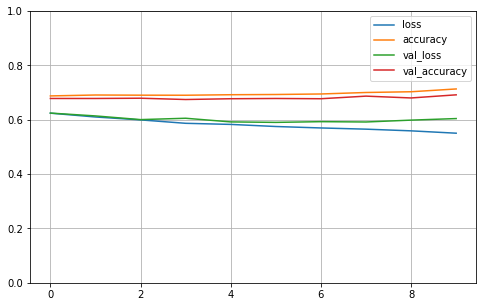

Compute valiation accuracy
2023-01-03 14:29:04.290136
Range of scores: 0.0042503974 to 0.87148595
Predicted zeros and ones 990 54
Accuracy: 69.16% Precision: 62.96% Recall: 10.12% F1: 17.44%
2023-01-03 14:29:04.503170
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (4869, 4997) (4869, 1)
Valid sizes (931, 4997) (931, 1)
Train set ones/size 1481 / 4869
Valid set ones/size 325 / 931
BUILD MODEL
COMPILE
FIT
2023-01-03 14:29:06.204436
Epoch 1/10
153/153 [==============================] - 2s 11ms/step - loss: 0.6222 - accuracy: 0.6958 - val_loss: 0.6468 - val_accuracy: 0.6509
Epoch 2/10
153/153 [==============================] - 1s 9ms/step - loss: 0.6070 - accuracy: 0.6958 - val_loss: 0.6495 - val_accuracy: 0.6509
Epoch 3/10
153/153 [==============================] - 1s 9ms/step - loss: 0.5995 - accuracy: 0.6944 - val_loss: 0.6265 - val_accuracy: 0.6520
Epoch 4/10
153/153 [==============================] - 1s 9ms/step - loss: 0.5853 - accuracy: 0.6952 - val_loss: 0.6062 -

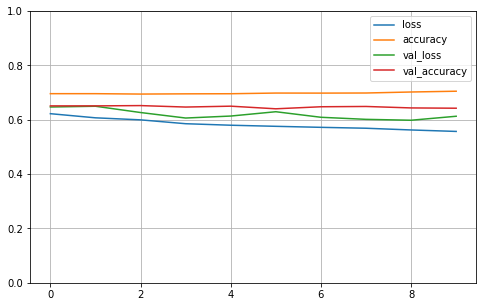

Compute valiation accuracy
2023-01-03 14:29:21.299890
Range of scores: 0.015741823 to 0.7239376
Predicted zeros and ones 889 42
Accuracy: 64.23% Precision: 40.48% Recall: 5.23% F1: 9.26%
2023-01-03 14:29:21.490025

Cross validation 5 folds 10 epochs
 accuracy mean 68.55% +/- 3.86
 precision mean 46.16% +/- 15.20
 recall mean 11.01% +/- 7.34
 F1 mean 17.29% +/- 9.95
2023-01-03 14:29:21.491898
-------------
2023-01-03 14:29:21.491956
Cell line for today: 12 = GM12878
Load RCI values...
Num RCI: 1698
Load genes...
2023-01-03 14:29:21.503996
Load sequence...
2023-01-03 14:29:29.230202
Num IDs: 5461
Count 1641 ones out of 5461 labels.
Num counts: 5461
2023-01-03 14:29:29.230897
splitting
Fold 1
Training example
[211  74  38 ...   0   0   0]
Train sizes (4496, 4997) (4496, 1)
Valid sizes (965, 4997) (965, 1)
Train set ones/size 1362 / 4496
Valid set ones/size 279 / 965
BUILD MODEL
COMPILE
FIT
2023-01-03 14:29:30.960216
Epoch 1/10
141/141 [==============================] - 3s 11ms/step - loss

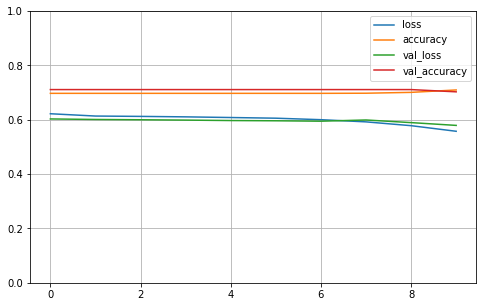

Compute valiation accuracy
2023-01-03 14:29:45.382575
Range of scores: 0.01968019 to 0.58190703
Predicted zeros and ones 951 14
Accuracy: 70.26% Precision: 21.43% Recall: 1.08% F1: 2.05%
2023-01-03 14:29:45.644611
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (4395, 4997) (4395, 1)
Valid sizes (1066, 4997) (1066, 1)
Train set ones/size 1346 / 4395
Valid set ones/size 295 / 1066
BUILD MODEL
COMPILE
FIT
2023-01-03 14:29:47.232901
Epoch 1/10
138/138 [==============================] - 2s 10ms/step - loss: 0.6238 - accuracy: 0.6942 - val_loss: 0.5908 - val_accuracy: 0.7233
Epoch 2/10
138/138 [==============================] - 1s 9ms/step - loss: 0.6152 - accuracy: 0.6937 - val_loss: 0.5956 - val_accuracy: 0.7233
Epoch 3/10
138/138 [==============================] - 1s 10ms/step - loss: 0.6141 - accuracy: 0.6937 - val_loss: 0.5957 - val_accuracy: 0.7233
Epoch 4/10
138/138 [==============================] - 1s 9ms/step - loss: 0.6112 - accuracy: 0.6937 - val_loss: 0.5882 -

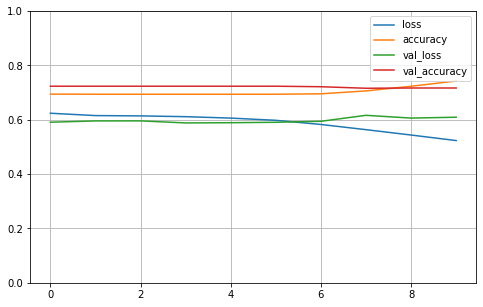

Compute valiation accuracy
2023-01-03 14:30:08.468410
Range of scores: 0.014299149 to 0.712706
Predicted zeros and ones 1039 27
Accuracy: 71.67% Precision: 37.04% Recall: 3.39% F1: 6.21%
2023-01-03 14:30:08.724555
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (4134, 4997) (4134, 1)
Valid sizes (1327, 4997) (1327, 1)
Train set ones/size 1262 / 4134
Valid set ones/size 379 / 1327
BUILD MODEL
COMPILE
FIT
2023-01-03 14:30:10.358067
Epoch 1/10
130/130 [==============================] - 2s 12ms/step - loss: 0.6252 - accuracy: 0.6947 - val_loss: 0.5986 - val_accuracy: 0.7144
Epoch 2/10
130/130 [==============================] - 1s 9ms/step - loss: 0.6139 - accuracy: 0.6947 - val_loss: 0.6025 - val_accuracy: 0.7144
Epoch 3/10
130/130 [==============================] - 1s 9ms/step - loss: 0.6122 - accuracy: 0.6947 - val_loss: 0.6018 - val_accuracy: 0.7144
Epoch 4/10
130/130 [==============================] - 1s 9ms/step - loss: 0.6104 - accuracy: 0.6947 - val_loss: 0.6040 - 

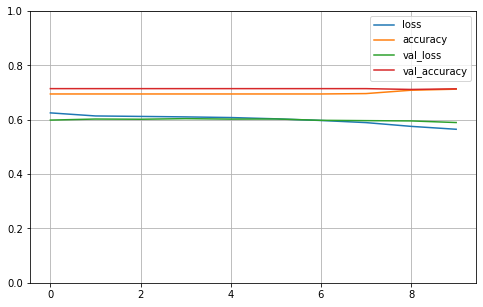

Compute valiation accuracy
2023-01-03 14:30:23.961110
Range of scores: 0.040170267 to 0.77932626
Predicted zeros and ones 1318 9
Accuracy: 71.36% Precision: 44.44% Recall: 1.06% F1: 2.06%
2023-01-03 14:30:24.223659
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (4522, 4997) (4522, 1)
Valid sizes (939, 4997) (939, 1)
Train set ones/size 1291 / 4522
Valid set ones/size 350 / 939
BUILD MODEL
COMPILE
FIT
2023-01-03 14:30:25.808318
Epoch 1/10
142/142 [==============================] - 2s 11ms/step - loss: 0.6118 - accuracy: 0.7143 - val_loss: 0.6792 - val_accuracy: 0.6273
Epoch 2/10
142/142 [==============================] - 1s 9ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.6654 - val_accuracy: 0.6273
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.5969 - accuracy: 0.7145 - val_loss: 0.6774 - val_accuracy: 0.6273
Epoch 4/10
142/142 [==============================] - 1s 9ms/step - loss: 0.5947 - accuracy: 0.7145 - val_loss: 0.6820 - v

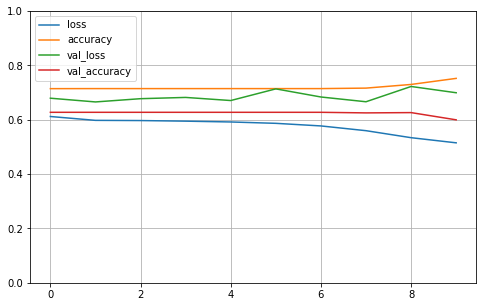

Compute valiation accuracy
2023-01-03 14:30:40.083372
Range of scores: 0.021591235 to 0.748126
Predicted zeros and ones 879 60
Accuracy: 59.96% Precision: 28.33% Recall: 4.86% F1: 8.29%
2023-01-03 14:30:40.292899
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (4297, 4997) (4297, 1)
Valid sizes (1164, 4997) (1164, 1)
Train set ones/size 1303 / 4297
Valid set ones/size 338 / 1164
BUILD MODEL
COMPILE
FIT
2023-01-03 14:30:41.883889
Epoch 1/10
135/135 [==============================] - 2s 11ms/step - loss: 0.6249 - accuracy: 0.6968 - val_loss: 0.6021 - val_accuracy: 0.7096
Epoch 2/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6133 - accuracy: 0.6968 - val_loss: 0.6027 - val_accuracy: 0.7096
Epoch 3/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6118 - accuracy: 0.6968 - val_loss: 0.6019 - val_accuracy: 0.7096
Epoch 4/10
135/135 [==============================] - 1s 9ms/step - loss: 0.6106 - accuracy: 0.6968 - val_loss: 0.6023 - v

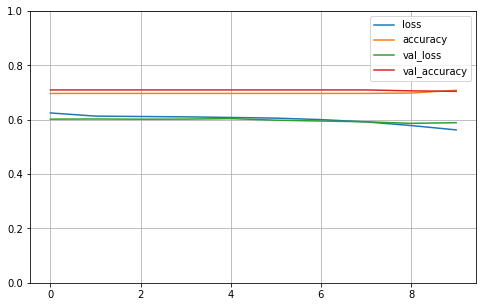

Compute valiation accuracy
2023-01-03 14:30:55.661844
Range of scores: 0.04814669 to 0.7779228
Predicted zeros and ones 1156 8
Accuracy: 70.45% Precision: 12.50% Recall: 0.30% F1: 0.58%
2023-01-03 14:30:55.923484

Cross validation 5 folds 10 epochs
 accuracy mean 68.74% +/- 4.42
 precision mean 28.75% +/- 11.25
 recall mean 2.13% +/- 1.71
 F1 mean 3.84% +/- 2.91
2023-01-03 14:30:55.924968
-------------
2023-01-03 14:30:55.925023
Cell line for today: 13 = K562
Load RCI values...
Num RCI: 958
Load genes...
2023-01-03 14:30:55.936551
Load sequence...
2023-01-03 14:31:00.891178
Num IDs: 3551
Count 1113 ones out of 3551 labels.
Num counts: 3551
2023-01-03 14:31:00.893478
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
Train sizes (2979, 4997) (2979, 1)
Valid sizes (572, 4997) (572, 1)
Train set ones/size 888 / 2979
Valid set ones/size 225 / 572
BUILD MODEL
COMPILE
FIT
2023-01-03 14:31:02.079198
Epoch 1/10
94/94 [==============================] - 2s 11ms/step - loss: 0.6218 -

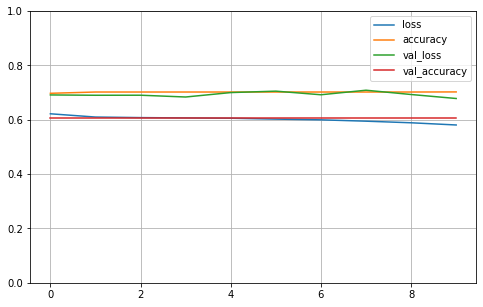

Compute valiation accuracy
2023-01-03 14:31:12.061176
Range of scores: 0.13872872 to 0.4990853
Predicted zeros and ones 572 0
Accuracy: 60.66% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:31:12.218985
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[121 228 142 ...   0   0   0]
Train sizes (2657, 4997) (2657, 1)
Valid sizes (894, 4997) (894, 1)
Train set ones/size 891 / 2657
Valid set ones/size 222 / 894
BUILD MODEL
COMPILE
FIT
2023-01-03 14:31:13.285140
Epoch 1/10
84/84 [==============================] - 2s 13ms/step - loss: 0.6488 - accuracy: 0.6647 - val_loss: 0.5841 - val_accuracy: 0.7517
Epoch 2/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6379 - accuracy: 0.6647 - val_loss: 0.5810 - val_accuracy: 0.7517
Epoch 3/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6367 - accuracy: 0.6647 - val_loss: 0.5749 - val_accuracy: 0.7517
Epoch 4/10
84/84 [==============================] - 1s 10ms/step - loss: 0.6356 - accuracy: 0.6647 - val_loss: 0.5755 - val_accuracy: 0.7517
Epoch 5/10
84/84 [==============================] - 1s 9ms/step - loss: 0.6342 - accuracy: 0.6647 - val_loss: 0.5781 - val_accuracy: 0.7517
Epoch 6/10
84/84 [==============================] - 1s 10ms/step - lo

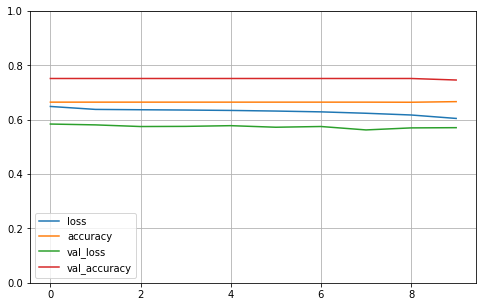

Compute valiation accuracy
2023-01-03 14:31:24.256383
Range of scores: 0.16471212 to 0.58834714
Predicted zeros and ones 889 5
Accuracy: 74.61% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:31:24.500911
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (2790, 4997) (2790, 1)
Valid sizes (761, 4997) (761, 1)
Train set ones/size 836 / 2790
Valid set ones/size 277 / 761
BUILD MODEL
COMPILE
FIT
2023-01-03 14:31:25.572033
Epoch 1/10
88/88 [==============================] - 2s 12ms/step - loss: 0.6273 - accuracy: 0.7004 - val_loss: 0.6588 - val_accuracy: 0.6360
Epoch 2/10
88/88 [==============================] - 1s 10ms/step - loss: 0.6106 - accuracy: 0.7004 - val_loss: 0.6649 - val_accuracy: 0.6360
Epoch 3/10
88/88 [==============================] - 1s 10ms/step - loss: 0.6091 - accuracy: 0.7004 - val_loss: 0.6689 - val_accuracy: 0.6360
Epoch 4/10
88/88 [==============================] - 1s 9ms/step - loss: 0.6077 - accuracy: 0.7004 - val_loss: 0.6704 - val_accuracy

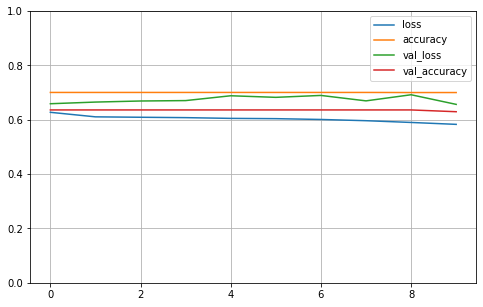

Compute valiation accuracy
2023-01-03 14:31:35.582383
Range of scores: 0.09794072 to 0.5703654
Predicted zeros and ones 754 7
Accuracy: 62.94% Precision: 14.29% Recall: 0.36% F1: 0.70%
2023-01-03 14:31:35.822937
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (2954, 4997) (2954, 1)
Valid sizes (597, 4997) (597, 1)
Train set ones/size 856 / 2954
Valid set ones/size 257 / 597
BUILD MODEL
COMPILE
FIT
2023-01-03 14:31:36.924710
Epoch 1/10
93/93 [==============================] - 2s 12ms/step - loss: 0.6136 - accuracy: 0.7102 - val_loss: 0.7376 - val_accuracy: 0.5695
Epoch 2/10
93/93 [==============================] - 1s 10ms/step - loss: 0.6018 - accuracy: 0.7102 - val_loss: 0.7284 - val_accuracy: 0.5695
Epoch 3/10
93/93 [==============================] - 1s 10ms/step - loss: 0.6007 - accuracy: 0.7102 - val_loss: 0.7323 - val_accuracy: 0.5695
Epoch 4/10
93/93 [==============================] - 1s 9ms/step - loss: 0.5994 - accuracy: 0.7102 - val_loss: 0.7245 - val_accuracy

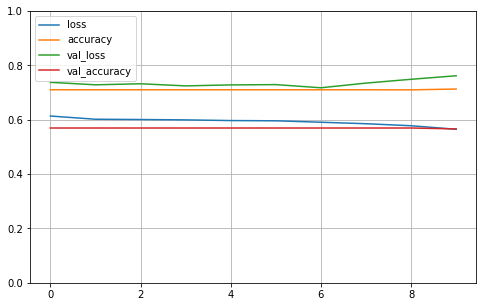

Compute valiation accuracy
2023-01-03 14:31:47.885012
Range of scores: 0.103186525 to 0.54928386
Predicted zeros and ones 595 2
Accuracy: 56.62% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 14:31:48.038970
Fold 5
Training example
[ 14  53 211 ...   0   0   0]
Train sizes (2824, 4997) (2824, 1)
Valid sizes (727, 4997) (727, 1)
Train set ones/size 981 / 2824
Valid set ones/size 132 / 727
BUILD MODEL
COMPILE
FIT
2023-01-03 14:31:49.092157
Epoch 1/10
89/89 [==============================] - 2s 11ms/step - loss: 0.6526 - accuracy: 0.6526 - val_loss: 0.5445 - val_accuracy: 0.8184
Epoch 2/10
89/89 [==============================] - 1s 10ms/step - loss: 0.6458 - accuracy: 0.6526 - val_loss: 0.5350 - val_accuracy: 0.8184
Epoch 3/10
89/89 [==============================] - 1s 10ms/step - loss: 0.6454 - accuracy: 0.6526 - val_loss: 0.5411 - val_accuracy: 0.8184
Epoch 4/10
89/89 [==============================] - 1s 10ms/step - loss: 0.6442 - accuracy: 0.6526 - val_loss: 0.5439 - val_accura

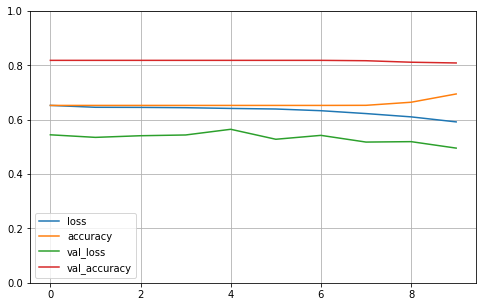

Compute valiation accuracy
2023-01-03 14:32:00.054631
Range of scores: 0.061033413 to 0.6366956
Predicted zeros and ones 716 11
Accuracy: 80.88% Precision: 18.18% Recall: 1.52% F1: 2.80%
2023-01-03 14:32:00.220046

Cross validation 5 folds 10 epochs
 accuracy mean 67.14% +/- 9.11
 precision mean 6.49% +/- 8.05
 recall mean 0.38% +/- 0.59
 F1 mean 0.70% +/- 1.08
2023-01-03 14:32:00.221004
-------------
2023-01-03 14:32:00.221058
Cell line for today: 14 = IMR.90
Load RCI values...
Num RCI: 390
Load genes...
2023-01-03 14:32:00.233550
Load sequence...
2023-01-03 14:32:02.338102
Num IDs: 1425
Count 492 ones out of 1425 labels.
Num counts: 1425
2023-01-03 14:32:02.338563
splitting
Fold 1
Training example
[22 88 94 ...  0  0  0]
Train sizes (1115, 4997) (1115, 1)
Valid sizes (310, 4997) (310, 1)
Train set ones/size 353 / 1115
Valid set ones/size 139 / 310
BUILD MODEL
COMPILE
FIT
2023-01-03 14:32:02.887434
Epoch 1/10
35/35 [==============================] - 1s 16ms/step - loss: 0.6503 - accur

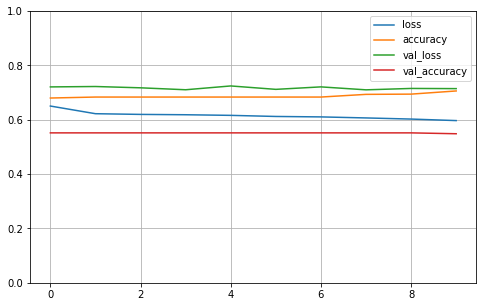

Compute valiation accuracy
2023-01-03 14:32:07.536977
Range of scores: 0.22178791 to 0.62969077
Predicted zeros and ones 305 5
Accuracy: 54.84% Precision: 40.00% Recall: 1.44% F1: 2.78%
2023-01-03 14:32:07.673630
Fold 2
Training example
[117 210  72 ...   0   0   0]
Train sizes (1140, 4997) (1140, 1)
Valid sizes (285, 4997) (285, 1)
Train set ones/size 424 / 1140
Valid set ones/size 68 / 285
BUILD MODEL
COMPILE
FIT
2023-01-03 14:32:08.142255
Epoch 1/10
36/36 [==============================] - 1s 14ms/step - loss: 0.6716 - accuracy: 0.6184 - val_loss: 0.5878 - val_accuracy: 0.7614
Epoch 2/10
36/36 [==============================] - 0s 10ms/step - loss: 0.6591 - accuracy: 0.6281 - val_loss: 0.5847 - val_accuracy: 0.7614
Epoch 3/10
36/36 [==============================] - 0s 11ms/step - loss: 0.6578 - accuracy: 0.6281 - val_loss: 0.5828 - val_accuracy: 0.7614
Epoch 4/10
36/36 [==============================] - 0s 11ms/step - loss: 0.6556 - accuracy: 0.6281 - val_loss: 0.5747 - val_accurac

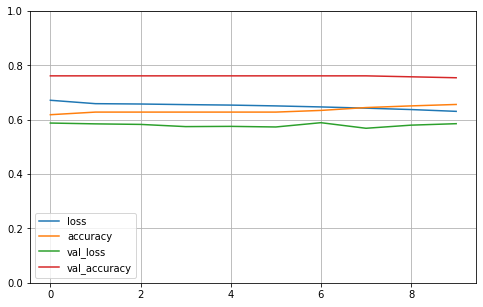

Compute valiation accuracy
2023-01-03 14:32:13.946870
Range of scores: 0.1902746 to 0.5404127
Predicted zeros and ones 279 6
Accuracy: 75.44% Precision: 33.33% Recall: 2.94% F1: 5.41%
2023-01-03 14:32:14.099421
Fold 3
Training example
[22 88 94 ...  0  0  0]
Train sizes (1115, 4997) (1115, 1)
Valid sizes (310, 4997) (310, 1)
Train set ones/size 362 / 1115
Valid set ones/size 130 / 310
BUILD MODEL
COMPILE
FIT
2023-01-03 14:32:14.580167
Epoch 1/10
35/35 [==============================] - 1s 17ms/step - loss: 0.6609 - accuracy: 0.6700 - val_loss: 0.6851 - val_accuracy: 0.5806
Epoch 2/10
35/35 [==============================] - 0s 12ms/step - loss: 0.6282 - accuracy: 0.6753 - val_loss: 0.6990 - val_accuracy: 0.5806
Epoch 3/10
35/35 [==============================] - 0s 10ms/step - loss: 0.6255 - accuracy: 0.6753 - val_loss: 0.6935 - val_accuracy: 0.5806
Epoch 4/10
35/35 [==============================] - 0s 11ms/step - loss: 0.6237 - accuracy: 0.6753 - val_loss: 0.7015 - val_accuracy: 0.58

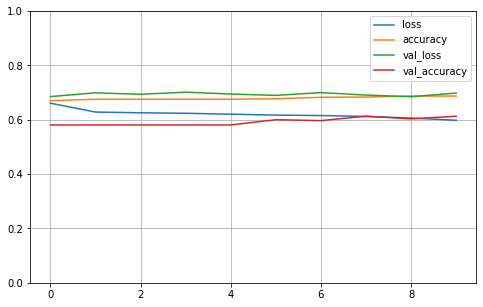

Compute valiation accuracy
2023-01-03 14:32:19.264980
Range of scores: 0.2100709 to 0.6123117
Predicted zeros and ones 296 14
Accuracy: 61.29% Precision: 85.71% Recall: 9.23% F1: 16.67%
2023-01-03 14:32:19.393715
Fold 4
Training example
[22 88 94 ...  0  0  0]
Train sizes (1173, 4997) (1173, 1)
Valid sizes (252, 4997) (252, 1)
Train set ones/size 431 / 1173
Valid set ones/size 61 / 252
BUILD MODEL
COMPILE
FIT
2023-01-03 14:32:19.855080
Epoch 1/10
37/37 [==============================] - 1s 14ms/step - loss: 0.6682 - accuracy: 0.6326 - val_loss: 0.5848 - val_accuracy: 0.7579
Epoch 2/10
37/37 [==============================] - 0s 10ms/step - loss: 0.6541 - accuracy: 0.6326 - val_loss: 0.5903 - val_accuracy: 0.7579
Epoch 3/10
37/37 [==============================] - 0s 9ms/step - loss: 0.6524 - accuracy: 0.6326 - val_loss: 0.5818 - val_accuracy: 0.7579
Epoch 4/10
37/37 [==============================] - 0s 9ms/step - loss: 0.6495 - accuracy: 0.6326 - val_loss: 0.5917 - val_accuracy: 0.757

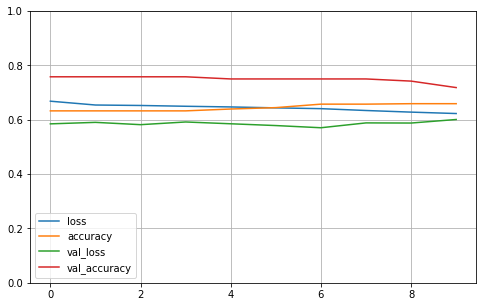

Compute valiation accuracy
2023-01-03 14:32:24.448064
Range of scores: 0.2860547 to 0.69697136
Predicted zeros and ones 224 28
Accuracy: 71.83% Precision: 32.14% Recall: 14.75% F1: 20.22%
2023-01-03 14:32:24.581525
Fold 5
Training example
[22 88 94 ...  0  0  0]
Train sizes (1157, 4997) (1157, 1)
Valid sizes (268, 4997) (268, 1)
Train set ones/size 398 / 1157
Valid set ones/size 94 / 268
BUILD MODEL
COMPILE
FIT
2023-01-03 14:32:25.036956
Epoch 1/10
37/37 [==============================] - 1s 14ms/step - loss: 0.6572 - accuracy: 0.6560 - val_loss: 0.6464 - val_accuracy: 0.6493
Epoch 2/10
37/37 [==============================] - 0s 10ms/step - loss: 0.6413 - accuracy: 0.6560 - val_loss: 0.6441 - val_accuracy: 0.6493
Epoch 3/10
37/37 [==============================] - 0s 10ms/step - loss: 0.6399 - accuracy: 0.6560 - val_loss: 0.6426 - val_accuracy: 0.6493
Epoch 4/10
37/37 [==============================] - 0s 11ms/step - loss: 0.6377 - accuracy: 0.6560 - val_loss: 0.6413 - val_accuracy: 0

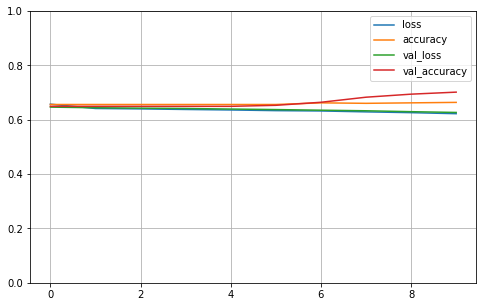

Compute valiation accuracy
2023-01-03 14:32:30.856950
Range of scores: 0.27747205 to 0.60442144
Predicted zeros and ones 250 18
Accuracy: 70.15% Precision: 88.89% Recall: 17.02% F1: 28.57%
2023-01-03 14:32:30.974182

Cross validation 5 folds 10 epochs
 accuracy mean 66.71% +/- 7.54
 precision mean 56.02% +/- 25.70
 recall mean 9.08% +/- 6.19
 F1 mean 14.73% +/- 9.54
2023-01-03 14:32:30.975046


In [45]:
for CELL_LINE_NUMBER in range(15):
    print('-------------')
    print(datetime.now())
    cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
    print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)
    print("Load RCI values...")
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
    print('Num RCI:', len(gene_to_rci.keys()))
    #print('Example RCI:', list(gene_to_rci.items())[:3])
    print("Load genes...")
    all_genes = list(gene_to_rci.keys())
    print(datetime.now())
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    labels,allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM
    print(datetime.now())
    print('Num IDs:',len(allids))
    #print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
    print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
    #print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
    print('Num counts:',len(allseq))
    #print('Example sequence:',allseq[3])
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
    print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(datetime.now())